# ПРОЕКТ "Анализ бизнес-показателей"

## Вводные данные:

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях,
выгрузка их покупок за этот период,
рекламные расходы.

Вам предстоит изучить:
откуда приходят пользователи и какими устройствами они пользуются,
сколько стоит привлечение пользователей из различных рекламных каналов;
сколько денег приносит каждый клиент,
когда расходы на привлечение клиента окупаются,
какие факторы мешают привлечению клиентов.


### План работы:
 - предобработка данных
 - исследовательский анализ данных:
   - создание профилей пользователей
   - количество и доля пользователей, разделённых по странам, устройствам и каналам привлечения
 - анализ расходов на маркетинг:
   - анализ расходов по каналам привлечения
   - стоимость привлечения одного пользователя в канале (САС)
 - оценка окупаемости рекламы:
   - окупаемость рекламы c помощью графиков LTV и ROI, и графиков динамики LTV, CAC и ROI
   - окупаемость рекламы с разбивкой по устройствам
   - окупаемость рекламы с разбивкой по каналам
   - окупаемость рекламы в США с разбивкой по каналам 
   - окупаемость рекламы в Европе с разбивкой по каналам
 - общий вывод   

In [67]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [68]:
#Загрузим данные
try: # яндекс
    visits = pd.read_csv('/.../visits_info_short.csv') #информация о посещениях
    orders = pd.read_csv('/.../orders_info_short.csv') #информация о заказах
    costs = pd.read_csv('/.../costs_info_short.csv') #информация о расходах на рекламу
except: # мой путь
    visits = pd.read_csv('visits_info_short.csv') #информация о посещениях
    orders = pd.read_csv('orders_info_short.csv') #информация о заказах
    costs = pd.read_csv('costs_info_short.csv') #информация о расходах на рекламу
    

## Предобработка данных. 


Смотрим информацию обо всех датасетах одним махом.

In [69]:
visits.info()
print()
costs.info()
print()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Coun

Переименуем столбцы в привычный формат:

In [70]:
visits = visits.rename(str.lower, axis='columns')
visits = visits.rename(columns={'user id': 'user_id','session start':'session_start', 'session end':'session_end'})
orders = orders.rename(columns={'User Id': 'user_id','Event Dt':'event_dt', 'Revenue':'revenue'})
costs = costs.rename(columns={'Channel': 'channel'})

Приведем типы данных к формату datetime в столбцах с датами. 

In [71]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Смотрим наличие дубликатов: 

In [72]:
print('Сумма дупликатов в датасете visits:', visits.duplicated().sum())
print()
print('Сумма дупликатов в датасете orders:', orders.duplicated().sum())
print()
print('Сумма дупликатов в датасете costs:', costs.duplicated().sum())
print()

Сумма дупликатов в датасете visits: 0

Сумма дупликатов в датасете orders: 0

Сумма дупликатов в датасете costs: 0



In [73]:
print('Сумма пропусков в датасете visits:') 
print(visits.isna().sum())
print()
print('Сумма пропусков в датасете orders:')
print(orders.isna().sum())
print()
print('Сумма пропусков в датасете costs:')
print(costs.isna().sum())
print()

Сумма пропусков в датасете visits:
user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

Сумма пропусков в датасете orders:
user_id     0
event_dt    0
revenue     0
dtype: int64

Сумма пропусков в датасете costs:
dt         0
channel    0
costs      0
dtype: int64



**ВЫВОД:**

В ходе предобработки данных были переименованы столбцы, изменены типы данных у дат, проверены данные на дубликаты и пропуски. 

## Исследовательский анализ данных

### Функция для создания пользовательских профилей. 

In [74]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['number_of_month'] = profiles['first_ts'].dt.month
    
    

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
 
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


**Составим профили пользователей**

In [75]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt  number_of_month  payer  acquisition_cost  
0  2019-05-07                5   True          1.088172  
1  2019-07-09                7  False          1.107237  
2  2019-10-01               10  False          0.000000  
3  2019-08-22                8  False          0.988235  
4  2019-10-02               10  False          0.230769

**Определим минимальную и максимальную даты привлечения пользователей.**

In [76]:
print('Минимальная дата привлечения: ', profiles['dt'].min())
print('Максимальная дата привлечения:', profiles['dt'].max() )
print(f'Разница {profiles["dt"].max() - profiles["dt"].min()}')

Минимальная дата привлечения:  2019-05-01
Максимальная дата привлечения: 2019-10-27
Разница 179 days, 0:00:00


### Выясним количество и долю пользователей, разделённых по странам, устройствам и каналам привлечения. 
Напишем функцию для подсчета общего количества и долей пользователей. 

In [77]:
def pivot_to_ratio(profiles, value=''):
    #составим сводную таблицу по устройствам и общему количеству пользователей
    total = profiles.pivot_table(index= value, values='user_id', aggfunc='count')
    #составим сводную таблицу по устройствам и количеству платящих пользователей
    ratio = profiles.query('payer==True').groupby(value).agg({'user_id': 'count'}) 
    #объединим обе таблицы
    total = total.merge(ratio, on= value).rename(columns={'user_id_x': 'total_users', 'user_id_y':'payers'})
    #посчитаем долю платящих пользователей от количества пользователей
    total['ratio'] = round((total['payers'] / total['total_users'])*100,2)
    #посчитаем долю платящих пользователей  к общему количеству пользователей
    total['ratio_to_total'] = round((total['payers']/sum(total['total_users'])*100),2)
    #отсортируем таблицу по доле пользователей
    total = total.sort_values('ratio_to_total')
    return total


**Выясним, из каких стран пользователи приходят в приложение и долю платящих пользователей из этих стран.**

In [78]:
region_total = pivot_to_ratio(profiles, value='region')
region_total

total_users  payers  ratio  ratio_to_total
region                                                   
Germany              14981     616   4.11            0.41
France               17450     663   3.80            0.44
UK                   17575     700   3.98            0.47
United States       100002    6902   6.90            4.60

In [79]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jpeg"

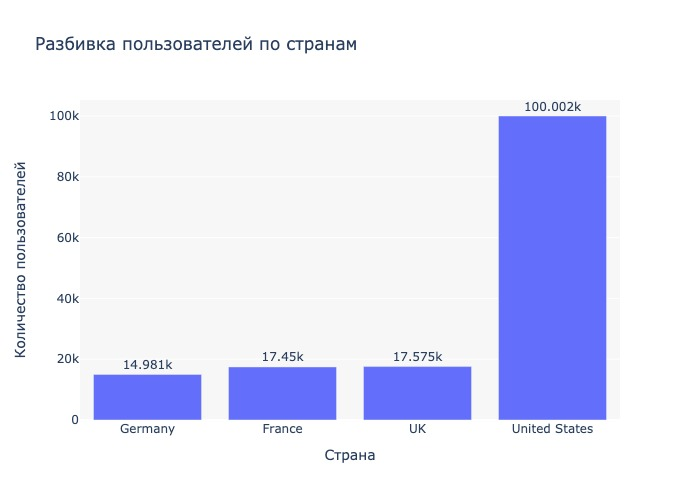

In [80]:
fig = px.bar(region_total.reset_index(), x='region', y='total_users', text_auto=True,
             title="Разбивка пользователей по странам")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(plot_bgcolor='#F7F7F7', 
                 xaxis_title='Страна',
                 yaxis_title='Количество пользователей')
fig.show()

**Вывод:** У нас есть 4 страны: США, Германия, Франция, Великобритания. Большая часть пользователей из США. Наибольшая доля платящих пользователей к количеству пользователей в регионе из США. И также наибольшая доля платящих пользователей к общему числу пользователей приходится на жителей США. 

**Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.**

In [81]:
device_total = pivot_to_ratio(profiles, value='device')
device_total

total_users  payers  ratio  ratio_to_total
device                                             
PC             30455    1537   5.05            1.02
Mac            30042    1912   6.36            1.27
Android        35032    2050   5.85            1.37
iPhone         54479    3382   6.21            2.25

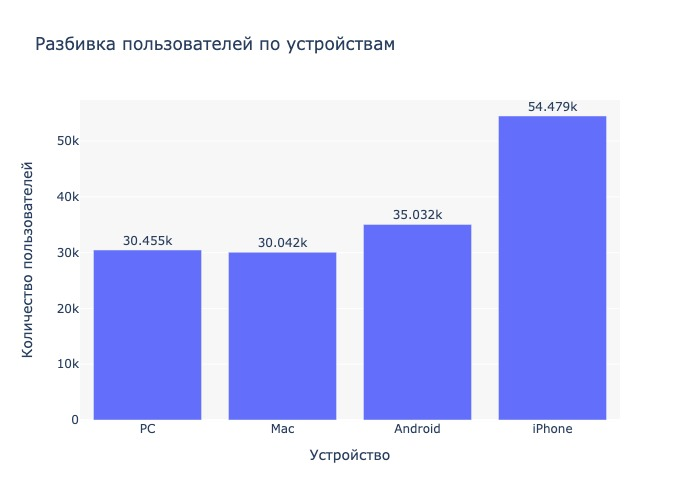

In [82]:
fig = px.bar(device_total.reset_index(), x='device', y='total_users', text_auto=True,
             title="Разбивка пользователей по устройствам")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(plot_bgcolor='#F7F7F7', 
                 xaxis_title='Устройство',
                 yaxis_title='Количество пользователей')
fig.show()

**Вывод:** Из данных видно, что у пользователей 4 вида устройств: РС, Мас, Android, iPhone. Распределение устройств: больше всего пользователей iPhone - 54,5 тыс. На втором месте Android - 35032. Другие устройства распределены в районе 30 тыс. Среди пользователей Мас больше всего платящих - 6,36%. Но, по отношению к общему числу пользователей наибольшая доля у пользователей iPhone - 2,25%. 

**Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.** 

In [83]:
channel_total = pivot_to_ratio(profiles, value='channel').sort_values('ratio_to_total')
channel_total

total_users  payers  ratio  ratio_to_total
channel                                                       
MediaTornado               4364     156   3.57            0.10
YRabbit                    4312     165   3.83            0.11
lambdaMediaAds             2149     225  10.47            0.15
OppleCreativeMedia         8605     233   2.71            0.16
LeapBob                    8553     262   3.06            0.17
RocketSuperAds             4448     352   7.91            0.23
AdNonSense                 3880     440  11.34            0.29
WahooNetBanner             8553     453   5.30            0.30
organic                   56439    1160   2.06            0.77
TipTop                    19561    1878   9.60            1.25
FaceBoom                  29144    3557  12.20            2.37

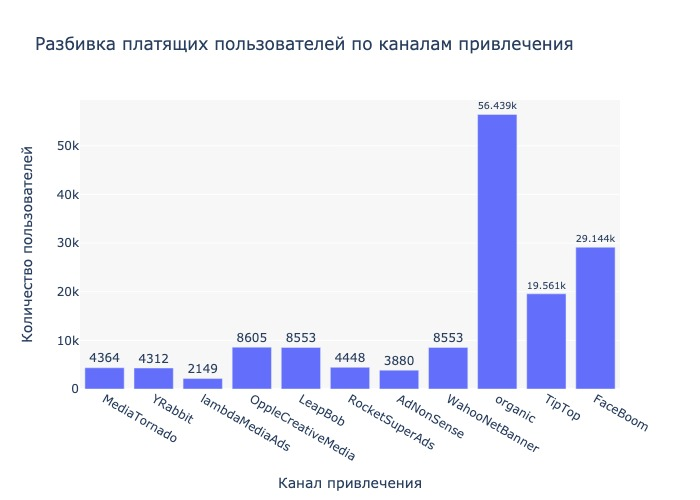

In [84]:
fig = px.bar(channel_total.reset_index(), x='channel', y='total_users', text_auto=True,
             title="Разбивка платящих пользователей по каналам привлечения")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(plot_bgcolor='#F7F7F7', 
                 xaxis_title='Канал привлечения',
                 yaxis_title='Количество пользователей')
fig.show()

**Вывод:** Из 11 каналов привлечения пользователей, больше всего трафика дают: organic, FaceBoom, TipTop. Наибольшая доля платящих пользователей к общему числу приходит от FaceBoom - 2,37%. Также у FaceBoom доля платящих к неплатящим пользователям самая высокая - 12,20%. 

#### ОБЩИЙ ВЫВОД:  
Наибольшее число пользователей из США, пользователи предпочитают iPhone. 
FaceBoom - канал привлечения, дающий больше всего платящих пользователей. 

## Анализ расходов на маркетинг. 

**Посчитаем общую сумму расходов на маркетинг**

In [85]:
print('Общая сумма расходов:', round(costs['costs'].sum(),2))

Общая сумма расходов: 105497.3


Посмотрим траты по источникам рекламы. 

In [86]:
channels_costs = costs.groupby('channel').agg({'costs':'sum'}).sort_values('costs', ascending=False).reset_index()
channels_costs['ratio'] = round(channels_costs['costs']/sum(channels_costs['costs']), 2) #доля затрат канала к общей сумме
channels_costs

channel     costs  ratio
0              TipTop  54751.30   0.52
1            FaceBoom  32445.60   0.31
2      WahooNetBanner   5151.00   0.05
3          AdNonSense   3911.25   0.04
4  OppleCreativeMedia   2151.25   0.02
5      RocketSuperAds   1833.00   0.02
6             LeapBob   1797.60   0.02
7      lambdaMediaAds   1557.60   0.01
8        MediaTornado    954.48   0.01
9             YRabbit    944.22   0.01

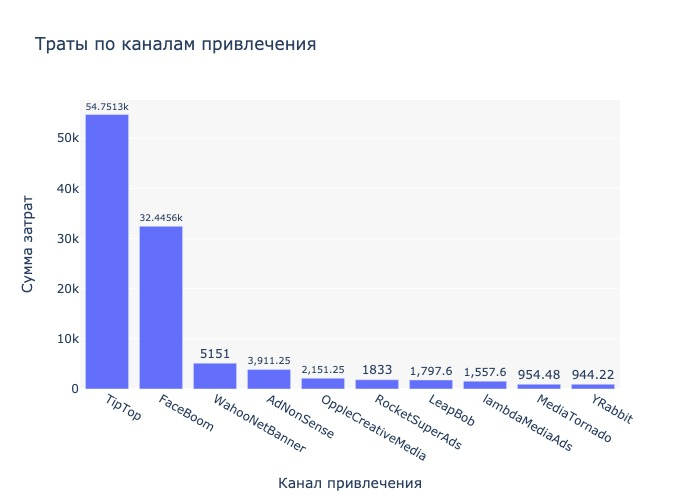

In [87]:
fig = px.bar(channels_costs, x='channel', y='costs', text_auto=True,
             title="Траты по каналам привлечения")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(plot_bgcolor='#F7F7F7', 
                 xaxis_title='Канал привлечения',
                 yaxis_title='Сумма затрат')
fig.show()

Наибольшая доля затрат приходится на два канала: TipTop (52%) и FaceBoom(31%). 

Посмотрим динамику изменения расходов во времени по каждому источнику. 

In [88]:
costs['week'] =pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month']=pd.to_datetime(costs['dt']).dt.month

In [89]:
monthly_costs = costs.pivot_table(index=['month'], columns='channel', values='costs', aggfunc='sum')
monthly_costs

channel  AdNonSense  FaceBoom  LeapBob  MediaTornado  OppleCreativeMedia  \
month                                                                      
5           1169.70    3524.4   140.28        238.56              169.75   
6            538.65    5501.1   314.58        138.00              370.00   
7            504.00    5294.3   313.53        138.48              366.50   
8            579.60    6274.4   369.81        154.56              439.25   
9            581.70    6114.9   343.98        144.72              427.75   
10           537.60    5736.5   315.42        140.16              378.00   

channel  RocketSuperAds   TipTop  WahooNetBanner  YRabbit  lambdaMediaAds  
month                                                                      
5               577.980   2981.0           418.8   299.70           458.4  
6               325.715   6675.6           921.0   106.20           199.2  
7               252.070   8410.2           851.4    97.38           219.2  
8               253.110  11202.0          1040.4   124.74           220.0  
9               218.400  13232.5           977.4   152.79           247.2  
10              205.725  12250.0           942.0   163.41           213.6

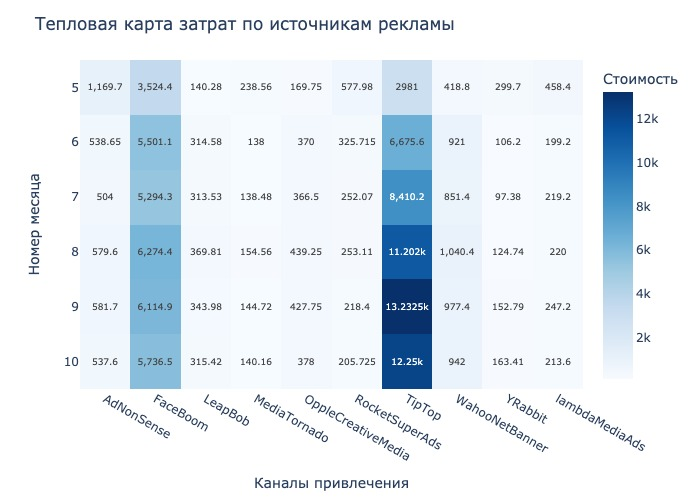

In [90]:
fig = px.imshow(monthly_costs.loc[:,'AdNonSense':'lambdaMediaAds'],  text_auto=True, color_continuous_scale='blues',
               labels=dict(x="Каналы привлечения", y="Номер месяца", color='Стоимость'))
fig.update_layout(title='Тепловая карта затрат по источникам рекламы')
fig.show()

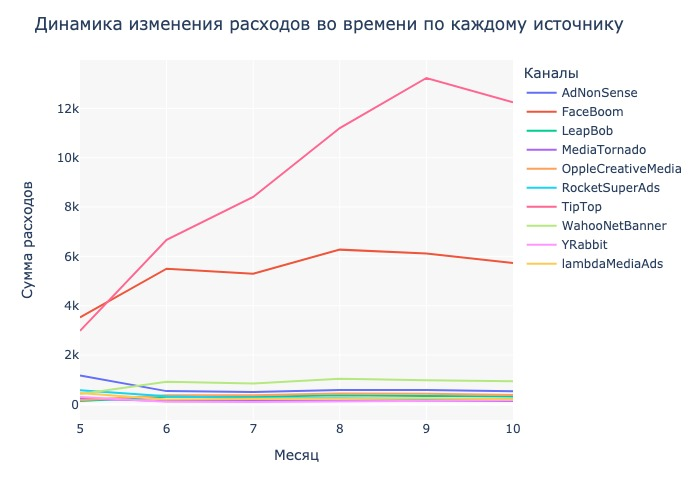

In [91]:
fig = px.line(monthly_costs.reset_index(), x = "month", y = list(monthly_costs.columns))
fig.update_layout(plot_bgcolor='#F7F7F7', title='Динамика изменения расходов во времени по каждому источнику',
                 xaxis_title='Месяц',
                 yaxis_title='Сумма расходов',
                 legend_title_text='Каналы')
fig.show()


In [92]:
weekly_costs = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
weekly_costs.head()

channel  AdNonSense  FaceBoom  LeapBob  MediaTornado  OppleCreativeMedia  \
week                                                                       
18           211.05     535.7    16.80         38.64               24.00   
19           273.00     750.2    31.71         61.68               34.50   
20           265.65     755.7    26.67         59.04               27.50   
21           266.70     722.7    26.67         50.16               34.25   
22           202.65    1208.9    65.52         36.96               81.75   

channel  RocketSuperAds  TipTop  WahooNetBanner  YRabbit  lambdaMediaAds  
week                                                                      
18               99.450   347.0            49.2     52.2            81.6  
19              139.230   470.0            92.4     75.9           103.2  
20              138.060   454.0            90.0     69.3            90.4  
21              131.040   801.8            79.2     65.4           119.2  
22               97.695  1421.2           179.4     49.8            83.2

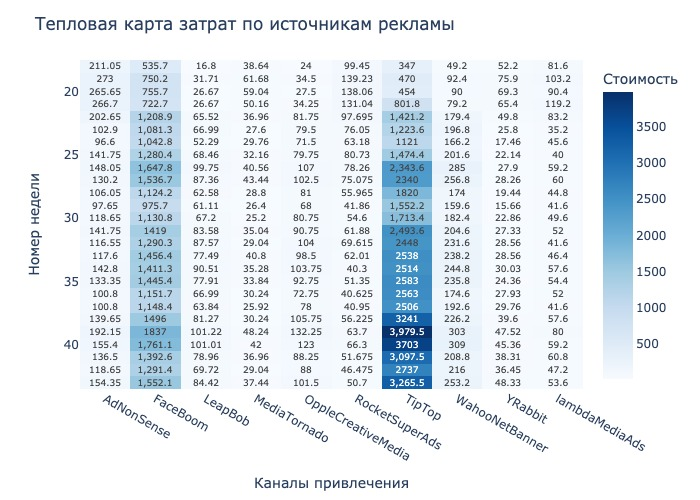

In [93]:
fig = px.imshow(weekly_costs.loc[:,'AdNonSense':'lambdaMediaAds'],  text_auto=True, color_continuous_scale='blues',
                labels=dict(x="Каналы привлечения", y="Номер недели", color='Стоимость'))
fig.update_layout(title='Тепловая карта затрат по источникам рекламы')
fig.show()

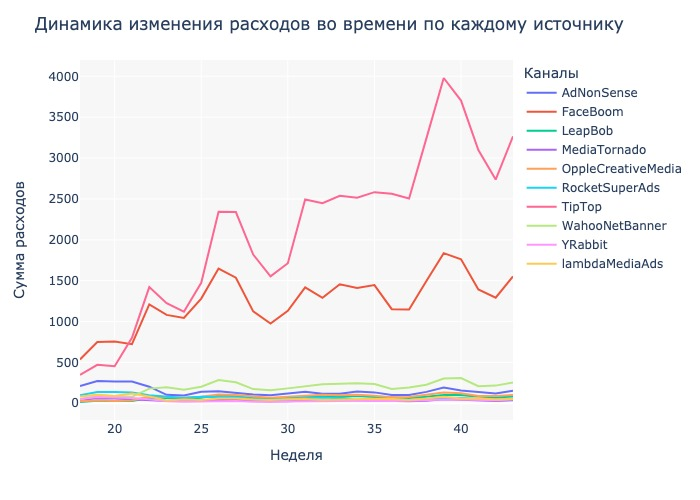

In [94]:
fig = px.line(weekly_costs, x = weekly_costs.index, y = list(weekly_costs.columns))
fig.update_layout(plot_bgcolor='#F7F7F7', title='Динамика изменения расходов во времени по каждому источнику',
                 xaxis_title='Неделя',
                 yaxis_title='Сумма расходов',
                 legend_title_text='Каналы')
fig.show()


Итак, в динамике __расходов по месяцам__ лидируют TipTop и FaceBoom. Расходы на TipTop растут с каждым месяцем и достигли 12 тыс. к сентябрю, в сентярбе начинают снижение. FaceBoom стабилизировались в августе (пик расходов 6,3тыс), нет резкого роста. По остальным каналам расходы стабильны и не превышают 1тыс. Если рассмотреть расходы более детально и разбить их на недели, то проявляется скачкообразый рост расходов в двух вышеуказанных каналах. У TipTop наблюдаем на 20, 24, 29 и 37 неделях. С 31 по 37 неделю расходы стабилизировались. У FaceBoom стабильности практически нет, но и скачки в расходах не такие резкие, как у TipTop.

**Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.**

In [95]:
profiles.head()

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt  number_of_month  payer  acquisition_cost  
0  2019-05-07                5   True          1.088172  
1  2019-07-09                7  False          1.107237  
2  2019-10-01               10  False          0.000000  
3  2019-08-22                8  False          0.988235  
4  2019-10-02               10  False          0.230769

In [96]:
cac = profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values('acquisition_cost', ascending = False).reset_index()
cac


channel  acquisition_cost
0               TipTop          2.799003
1             FaceBoom          1.113286
2           AdNonSense          1.008054
3       lambdaMediaAds          0.724802
4       WahooNetBanner          0.602245
5       RocketSuperAds          0.412095
6   OppleCreativeMedia          0.250000
7              YRabbit          0.218975
8         MediaTornado          0.218717
9              LeapBob          0.210172
10             organic          0.000000

In [97]:
print('Средняя стоимость привлечения пользователя составила:', cac['acquisition_cost'].mean())

Средняя стоимость привлечения пользователя составила: 0.6870317251013996


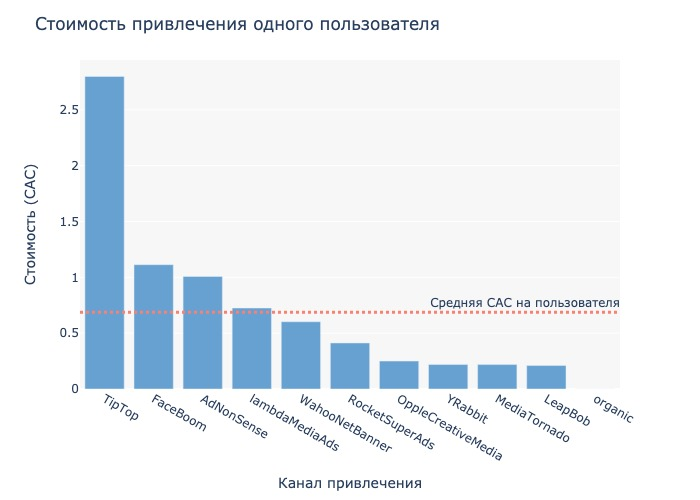

In [98]:
fig = px.bar(cac, y='acquisition_cost', x='channel', color_discrete_sequence=["#66A1D2"])
fig.update_layout(plot_bgcolor='#F7F7F7', title='Стоимость привлечения одного пользователя',
                 xaxis_title='Канал привлечения',
                 yaxis_title='Стоимость (САС)')
fig.add_shape( # add a horizontal "target" line
    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
    x0=0, x1=1, xref="paper", y0=cac['acquisition_cost'].mean(), y1=cac['acquisition_cost'].mean(), yref="y",
    label=dict(text="Средняя САС на пользователя", textposition="end")
    )
fig.show()

__Итого:__ три канала с превышением средней САС: TipTop (2.8), FaceBoom (1.11) и AdNonsense (1.00). Остальные каналы привлекают пользователей дешевле средней САС. Заметим что привлечение через TipTop превышает показатель больше, чем в 3 раза. 

## Оценим окупаемость рекламы. 

Создадим все необходимые функции для расчетов:

-- функция для расчета LTV и ROI

In [99]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

-- функция для сглаживания фрейма

In [100]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

-- функция для визуализации LTV и ROI

In [101]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

-- функция для расчёта конверсии

In [102]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

-- функция для визуализации конверсии

In [103]:
def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


-- функция для расчёта удержания

In [104]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

-- функция для визуализации удержания

In [105]:
def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.**

In [106]:
#Установим момент и горизонт анализа данных
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

In [107]:
#отфильтруем профили. Удалим органических пользователей. 
profiles = profiles.query('channel != "organic"')

In [108]:
#считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)

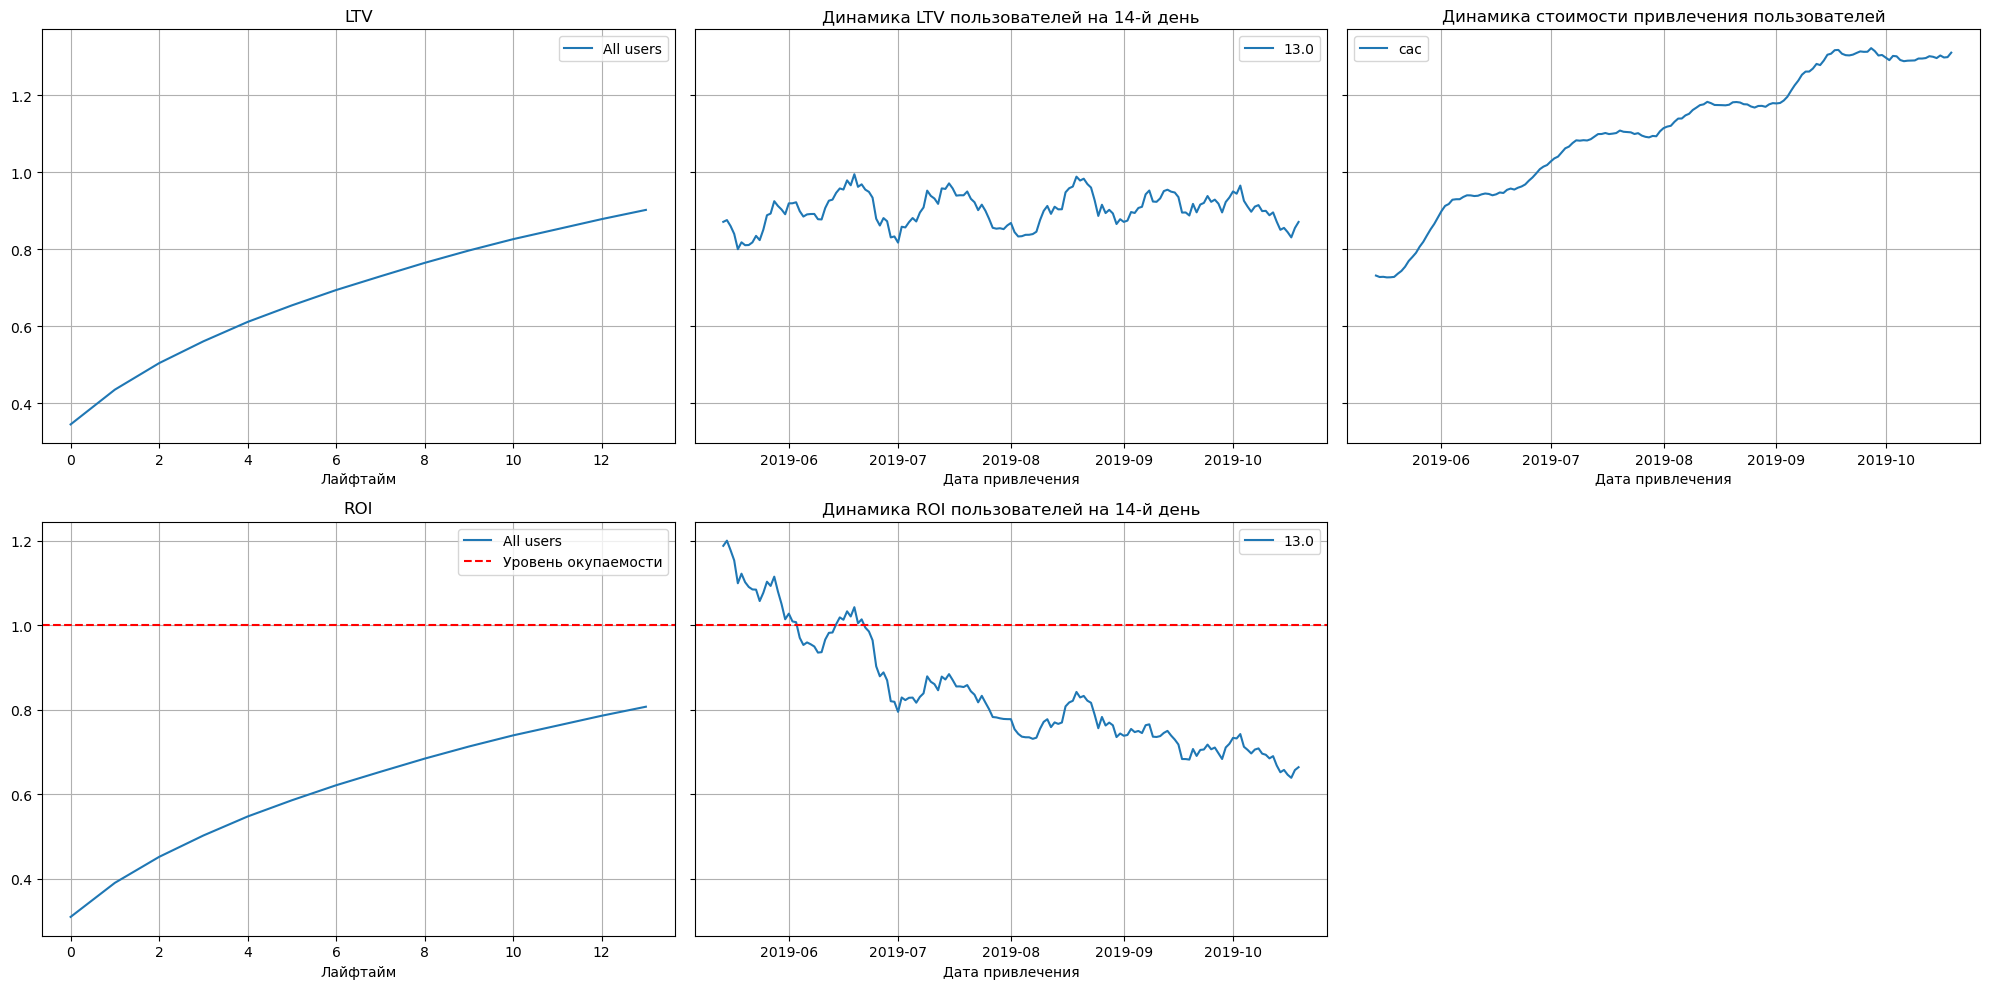

In [109]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Вывод:** реклама не окупается. К 14му дню лайфтайма ROI достигает только 80%. Динамика ROI на 14 день снизилась до 60%. При этом стоимость привлечения пользователей выросла почти в 2 раза. LTV также не достигает 100% за 14-дневный срок, зато динамика более менее стабильна - колеблется в диапазоне от 80 до 100%.  

**Проверим конверсию пользователей и динамику её изменения.**

In [110]:
#считаем конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

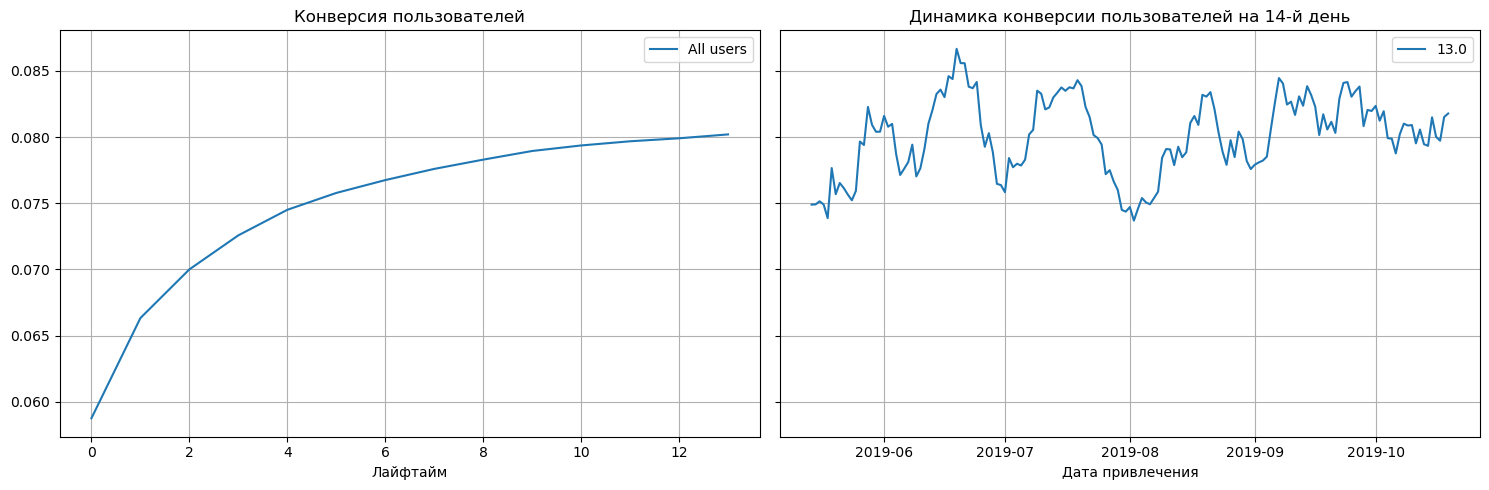

In [111]:
#строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

In [112]:
#считаем удержание
retention_raw, retention, retention_history = get_retention(profiles, visits, observation_date, horizon_days)

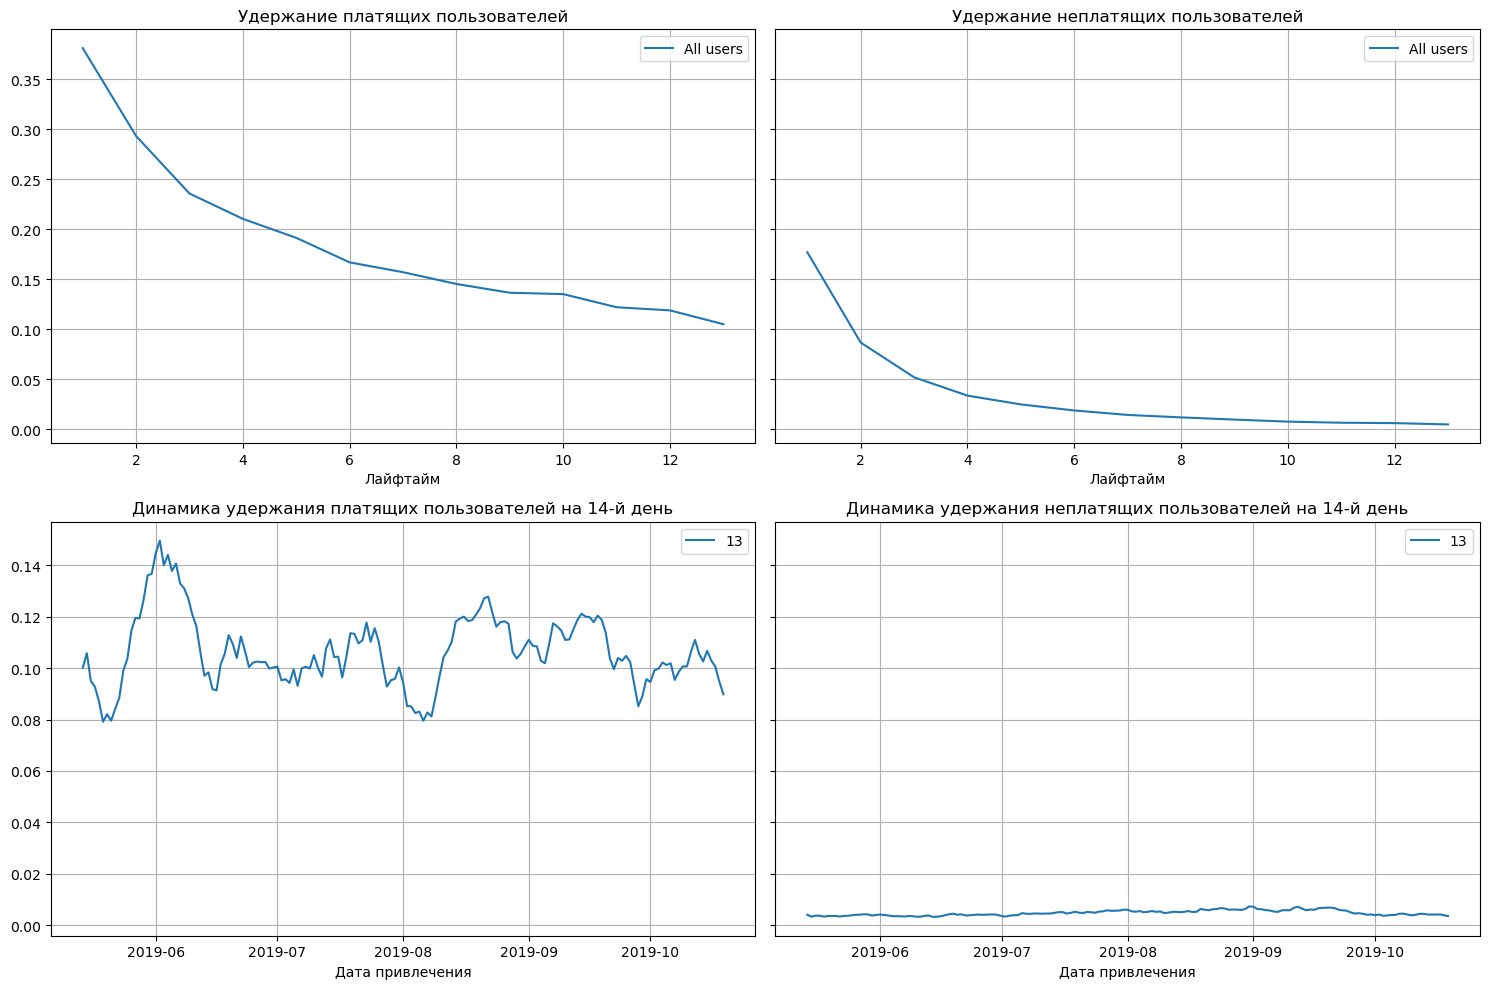

In [113]:
#строим графики
plot_retention(retention, retention_history, horizon_days)

**Вывод:** низкое удержание платящих пользователей и катастрофическое неплатящих. Падение метрики с 35% до 10% за 14 дней. На 14-й день динамика удержания платящих колеблется от 12 до 9 процентов. У неплатящих показатель практически равен нулю. Нужно смотреть метрики отдельно по параметрам. 

### Рассмотрим окупаемость рекламы с разбивкой по устройствам

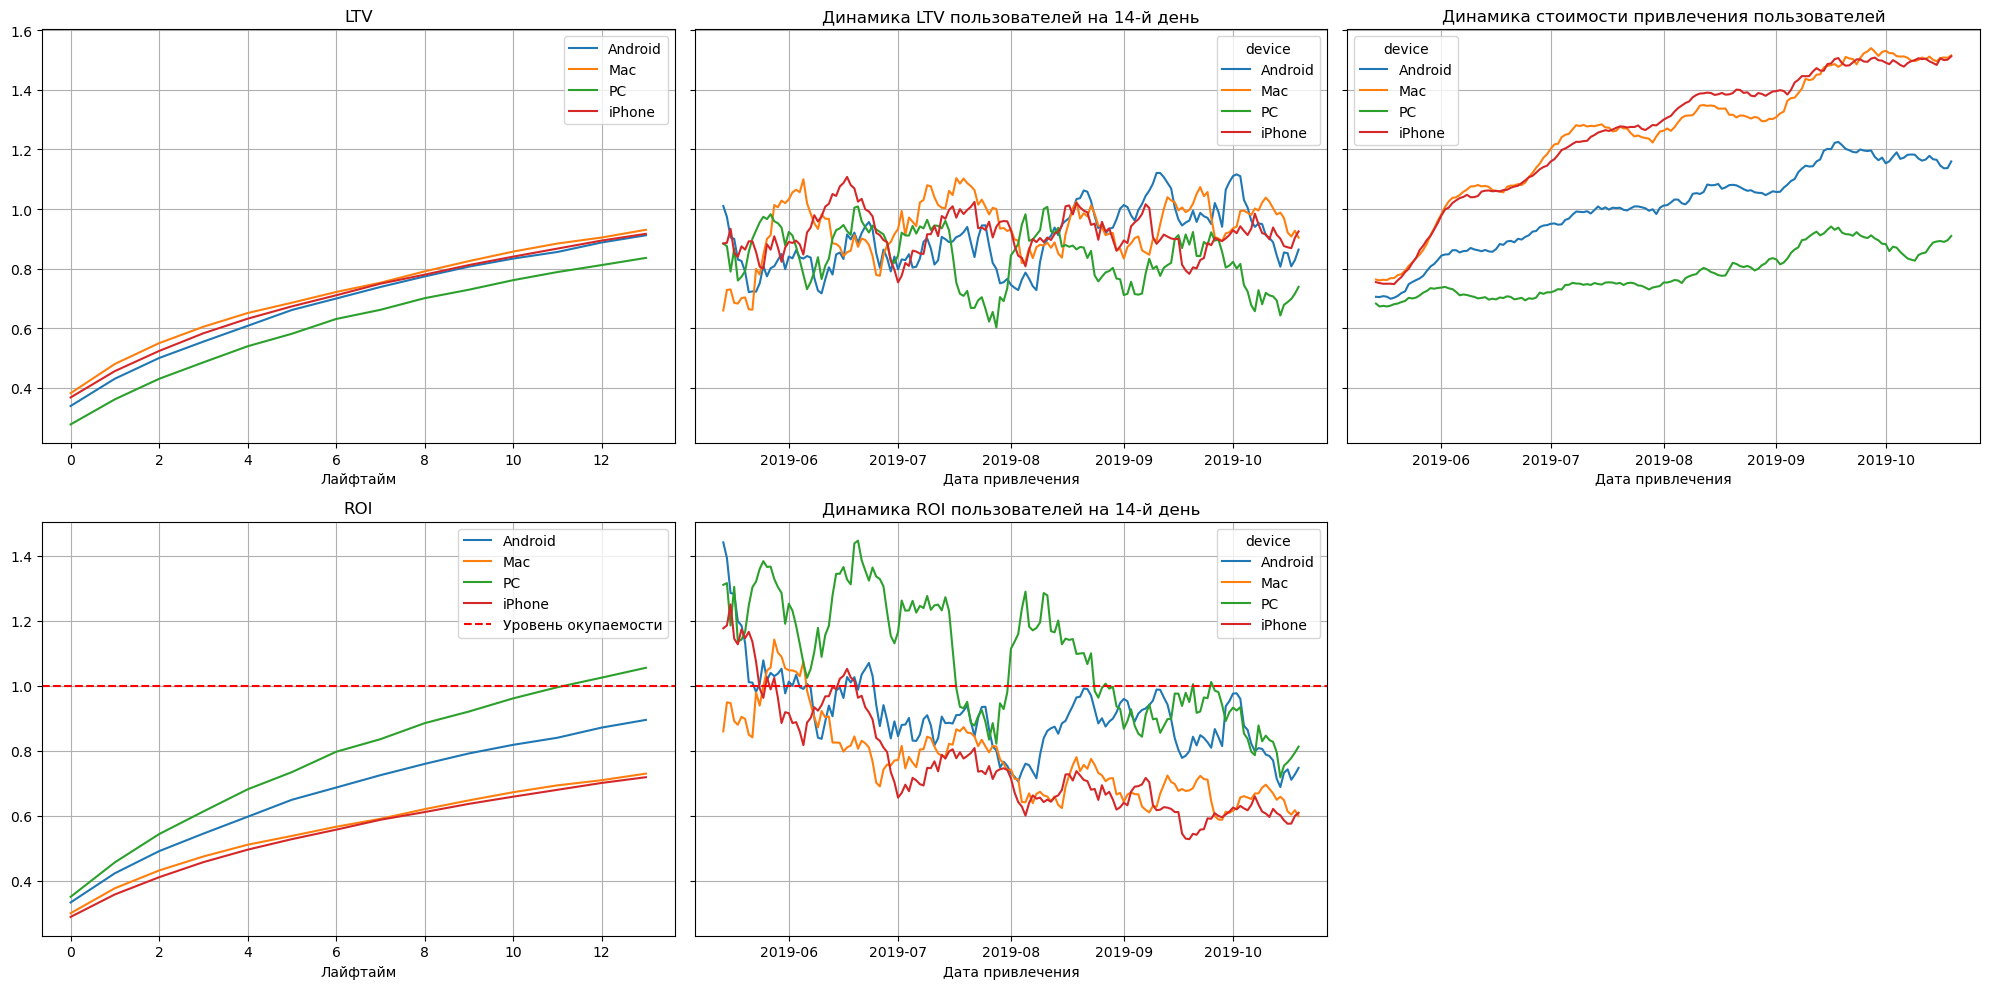

In [114]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=['device'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Только у пользователей РС показатель ROI выходит на окупаемость, возможно это связано с тем, что затраты на привлечение таких пользователей самые низкие. Также замечу, что ROI у пользователей РС окупается на 12 день только. К тому же уровень LTV у РС ниже, чем у остальных. Значит они приносят компании меньше денег и при этом окупаются. Судя по динамике ROI до сентября 2019 года такие пользователи окупались очень хорошо. В то же время, затраты на привлечение начали расти тоже в сентябре. Значит тут есть связь - затраты выросли - ROI упал.  Посмотрим какими устройствами в каких странах пользуются больше:

In [115]:
regions_profiles = profiles.pivot_table(index='region', columns='device', values='user_id', aggfunc='count').reset_index()
regions_profiles

device         region  Android    Mac    PC  iPhone
0              France     3313   1163  4384    2198
1             Germany     2849   1020  3797    1862
2                  UK     3243   1086  4551    2274
3       United States    12436  15424  6421   27548

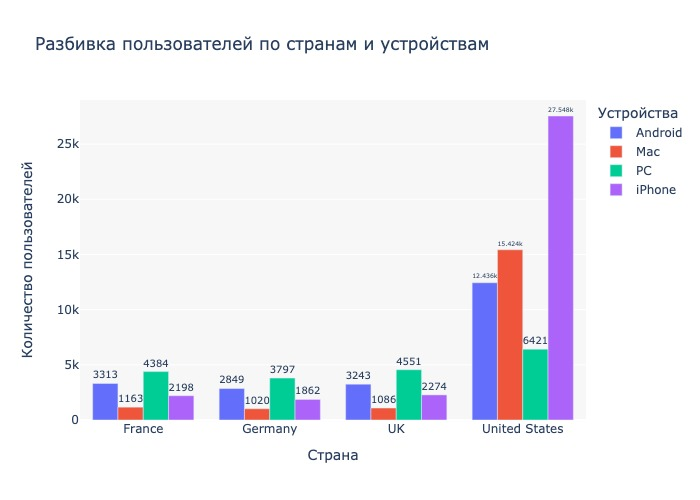

In [116]:
fig = px.bar(regions_profiles, x="region", y=['Android','Mac', 'PC','iPhone'], barmode='group', text_auto=True,
             title="Разбивка пользователей по странам и устройствам")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(plot_bgcolor='#F7F7F7', 
                 xaxis_title='Страна',
                 yaxis_title='Количество пользователей',
                 legend_title_text='Устройства')
fig.show()

Так как из США больше всего пользователей, очевидно, что они влияют на показатели сильнее всего. Итак, в США предпочитают пользоваться iPhone, Mac и Android и гораздо реже PC. Поэтому стоимость привлечения пользователей iPhone и Mac в динамике растет от когорты к когорте (от мая к ноябрю), а ROI наоборот падает. На этом фоне высокий ROI у РС вызывает вопросы. Нужно смотреть показатели в разбивке по странам. 

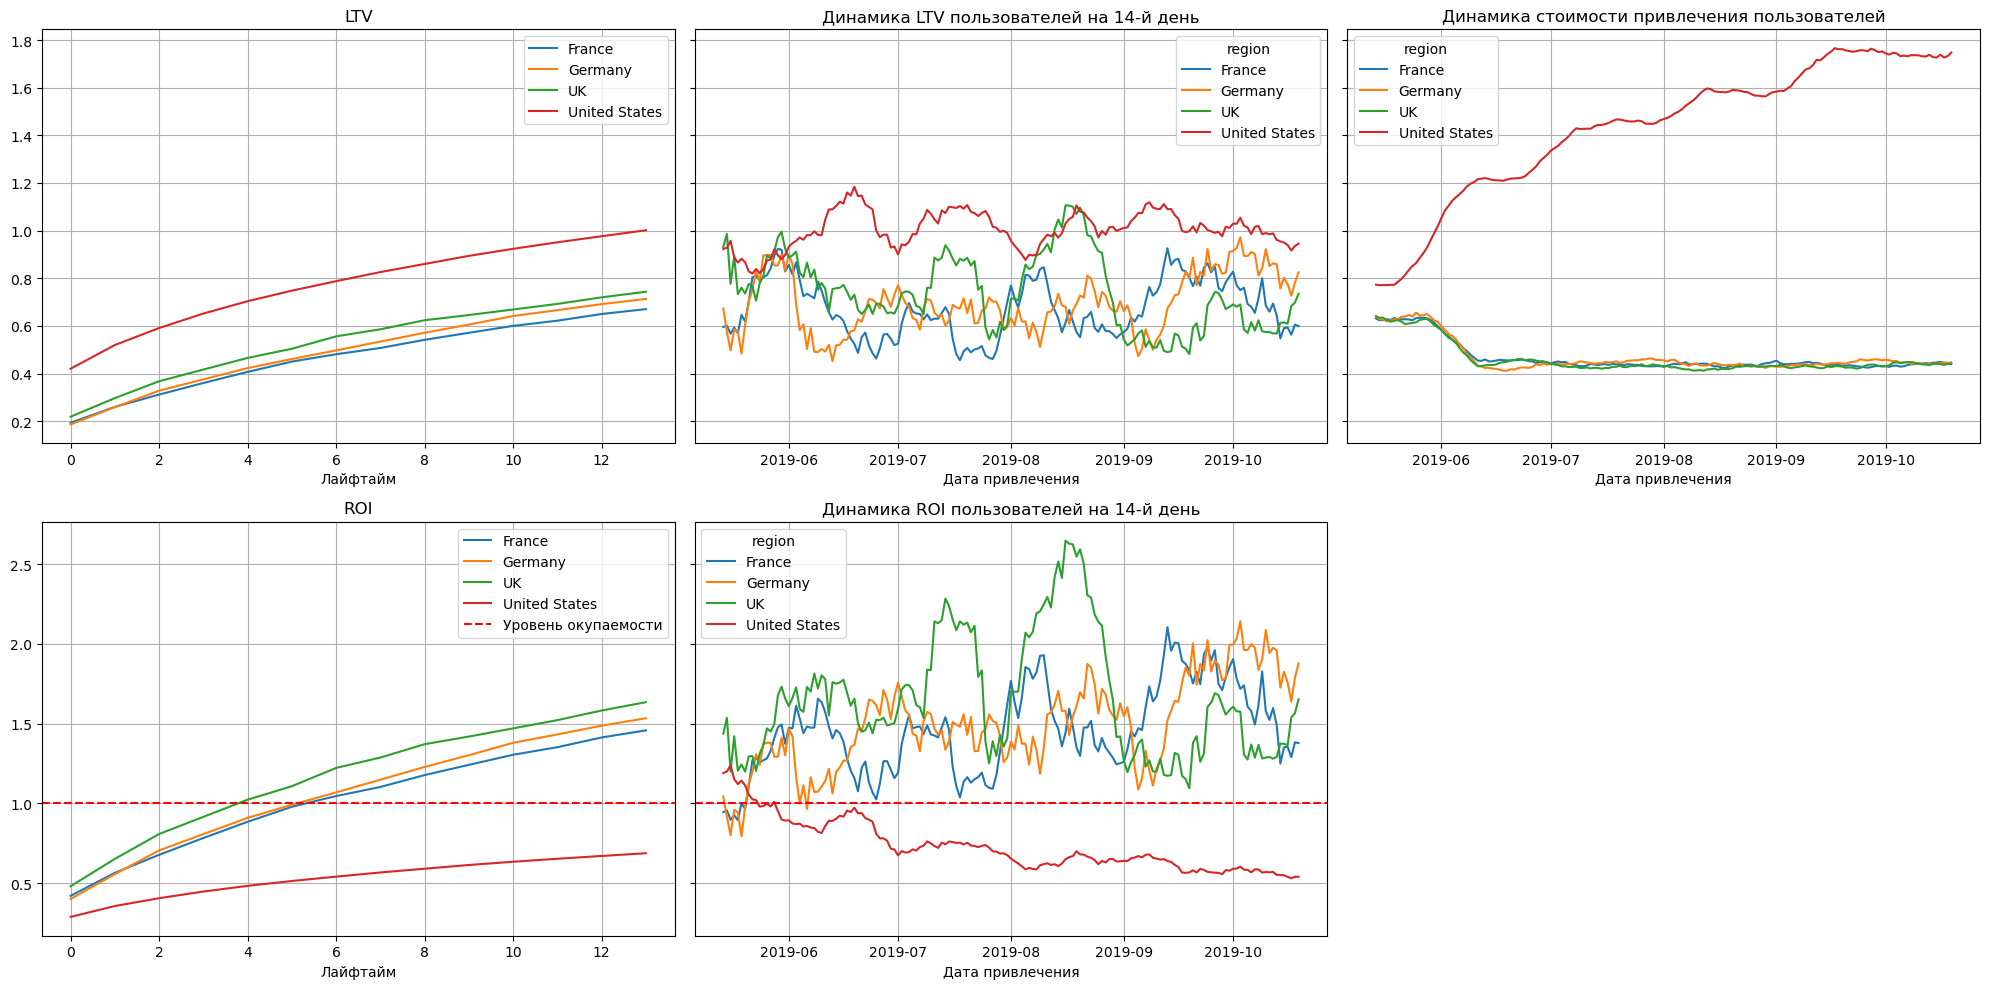

In [117]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=['region'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

LTV у США выше, чем у Европы. Значит американец покупает больше европейца. Об этом же нам говорит график динамики LTV: пользователи США стабильно выше пользователей из европейских стран. Уровень САС у США начал расти практически сразу и увеличился в 2 раза. В это же время стоимость привлечения европейского пользователя снизилась и стабилизировалась на уровне 0,4. ROI пользователя из США низкий, затраты на рекламу не окупаются ни в один из дней лайфтайма и не поднимаются выше 60%. В динамике мы видим снижение ROI буквально через месяц после старта приложения. Прослеживается корреляция между повышением САС и снижением ROI. У европейских пользователей все хорошо, даже не смотря на то, что LTV у них ниже. ROI на 5-7 день лайфтайма выходит на окупаемость и достигает 150%. В динамике все также хорошо, все три европейские страны находятся в зоне окупаемости. Посмотрим показатели в разрезе каналов привлечения.   

### Рассмотрим окупаемость рекламы с разбивкой по каналам привлечения

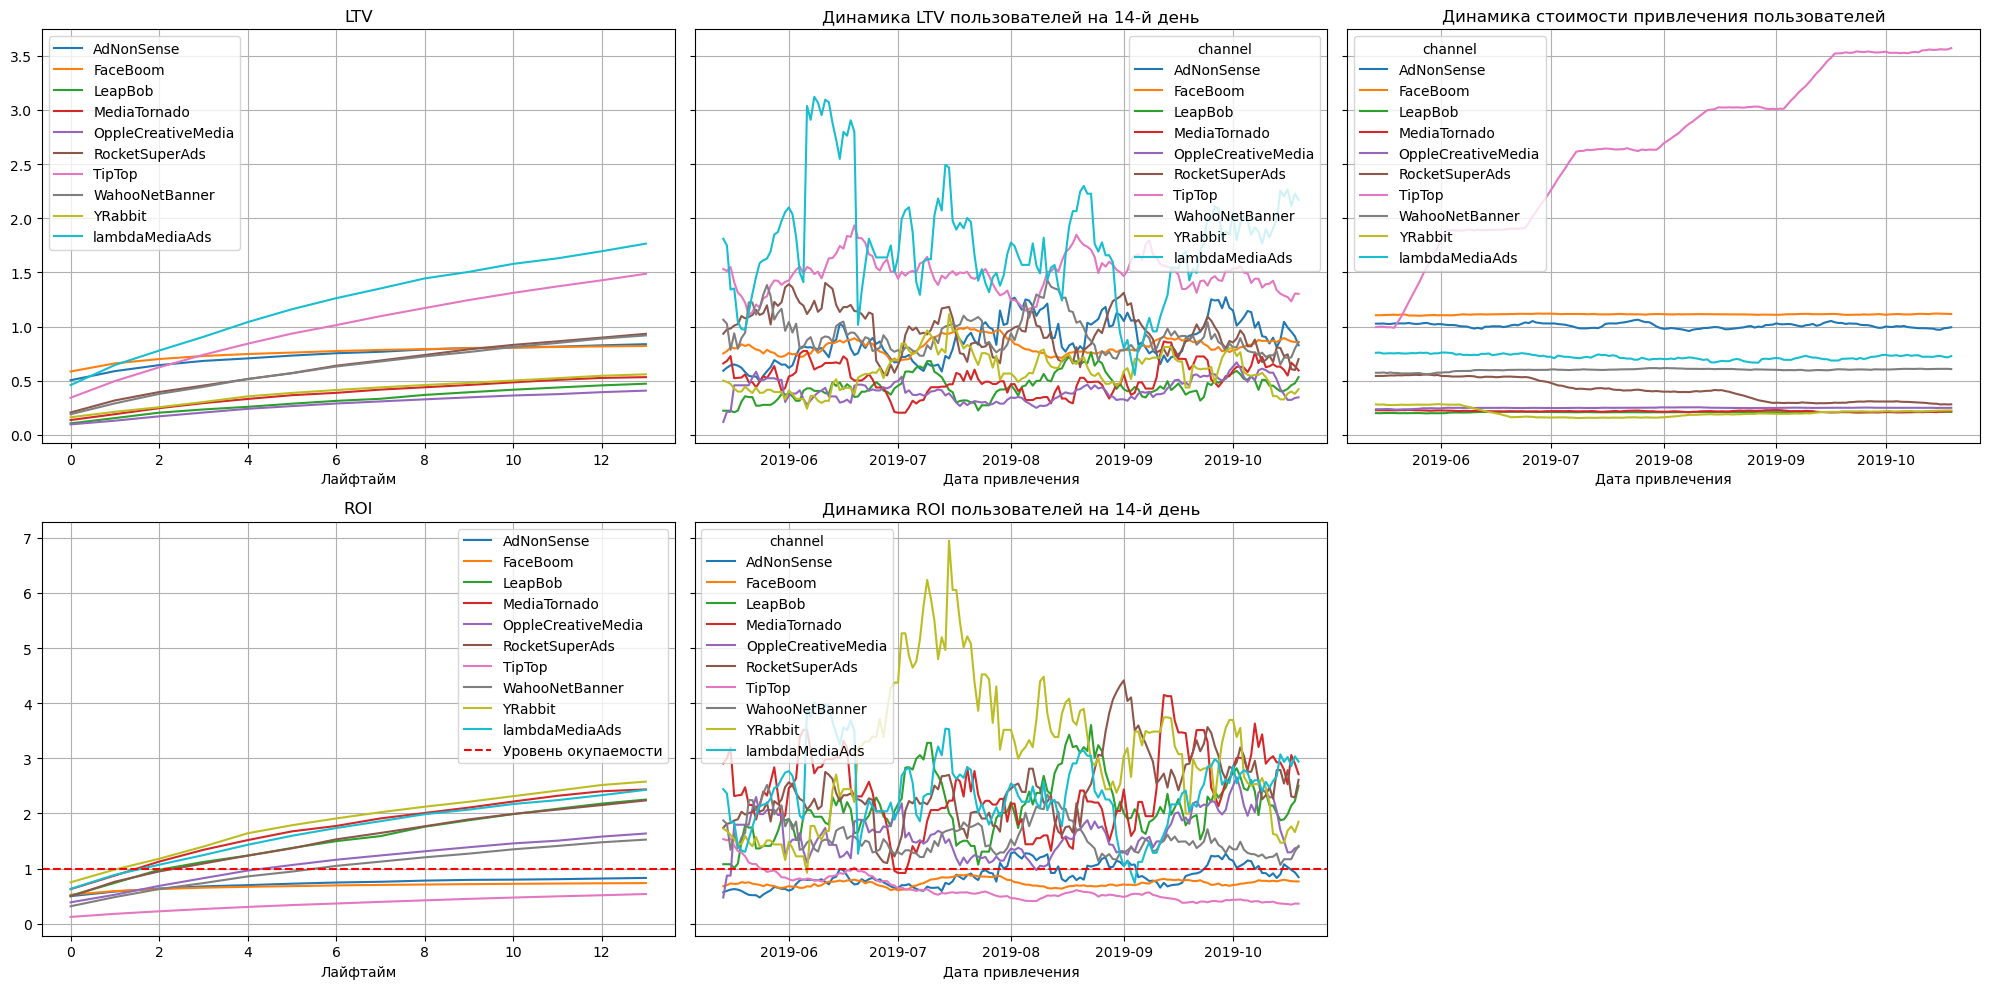

In [118]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Пользователи с самым высоким LTV приходят из lambdaMediaAds и TipTop, меньше всего платящих пользователей дают OppleCreativeMedia и LeapBob. Динамика САС у всех каналов стабильна, кроме  TipTop и RocketSuperAds. Стоимость пользователя из TipTop выросла в 3,5 раза, стоимость пользователя из RocketSuperAds снизилась в 2 раза. Не все каналы привлечения окупаются:  FaceBoom,AdNonSense и TipTop не выходят на уровень окупаемости. Остальные каналы со 2 по 7 день лайфтайма выходят за отметку 100%. Причем те, кто выходят раньше - дают ROI выше YRabbit, MediaTornado и lambdaMediaAds.

Рассмотрим подробнее затраты на привлчение пользователей по каналам и странам. Построим графики отдельно по двум регионам: США и Европа. 

**США, КАНАЛЫ ПРИВЛЕЧЕНИЯ**

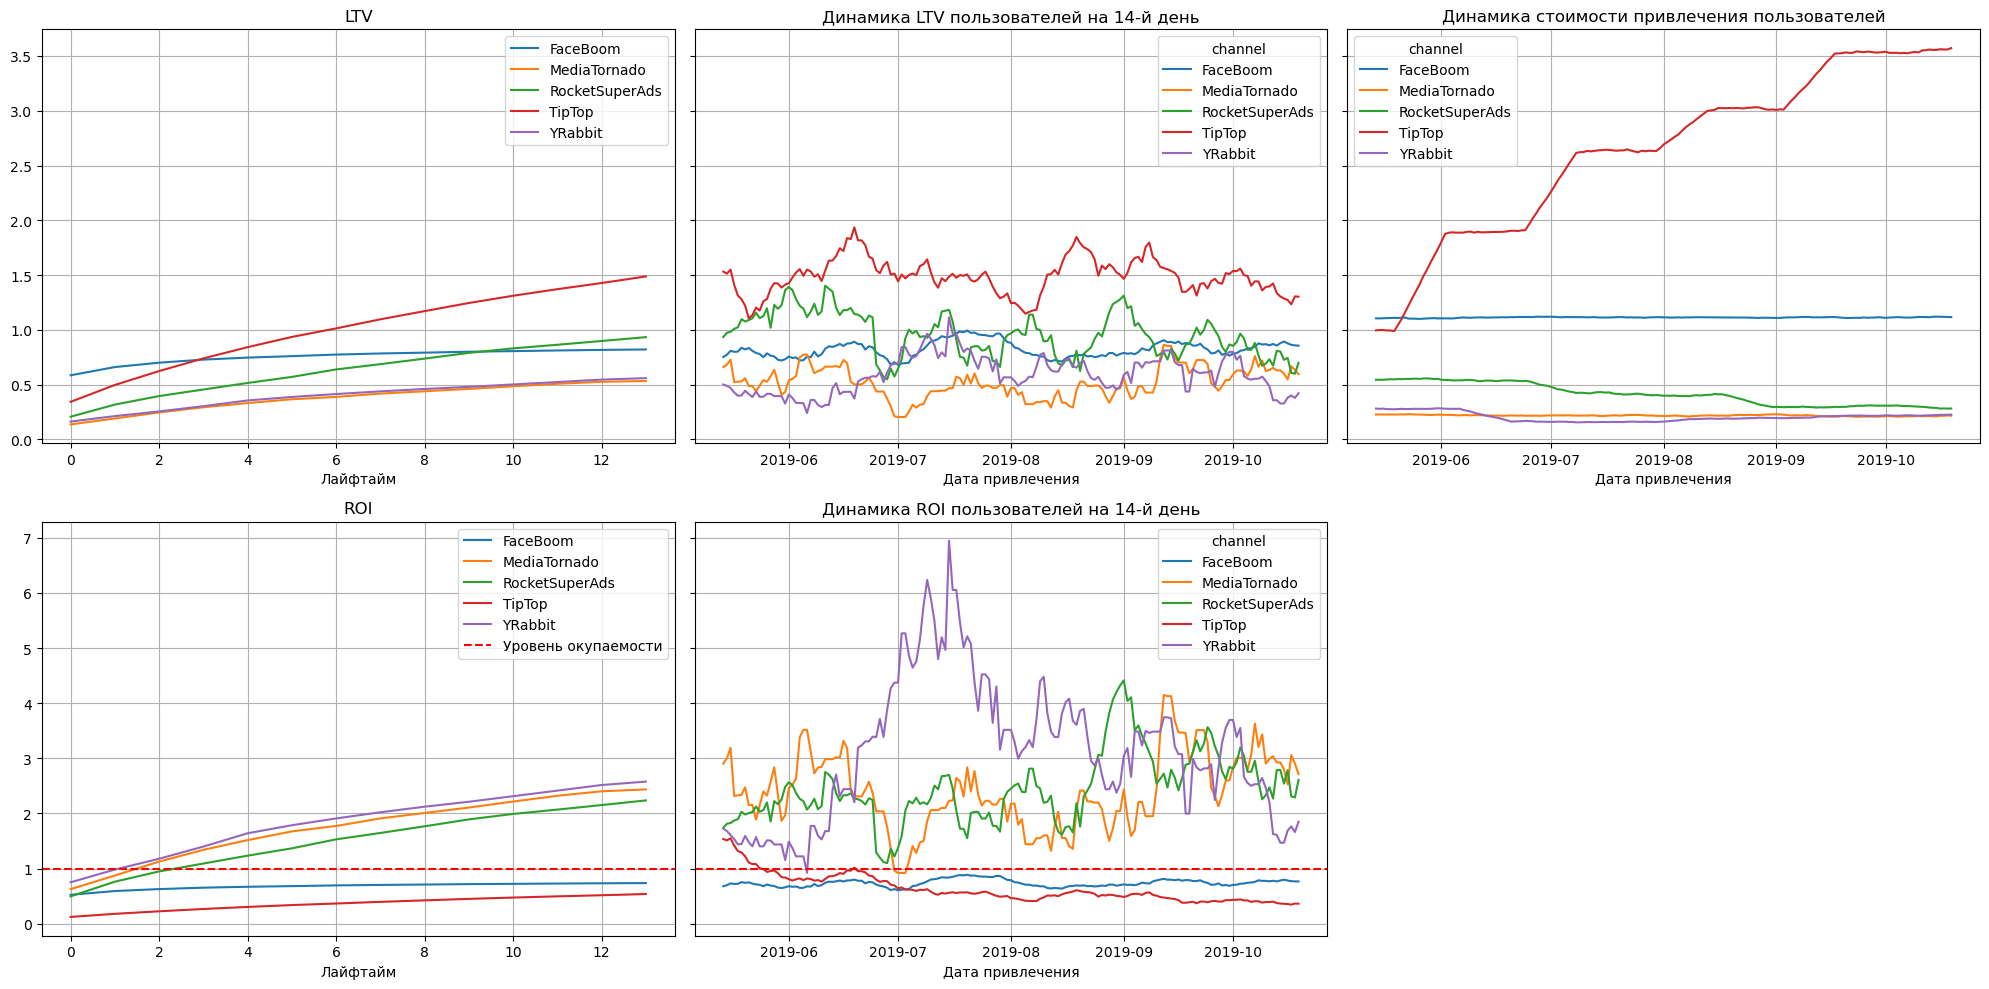

In [119]:
usa = profiles.query('region == "United States"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(usa, orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Итак, в США свои каналы для рекламы: FaceBoom, YRabbit, MediaTornado, RocketSuperAds и TipTop. У FaceBoom САС выше, чем LTV. Причем, LTV не такой как у остальных - он практический не растет. Пользователи TipTop дают больше всего LTV, и стоят с каждым месяцем все дороже, а ROI схож с ROI FaceBoom, только ниже. И тоже не окупаются. Посмотрим конверсию и удержание пользователей в этих каналах. 

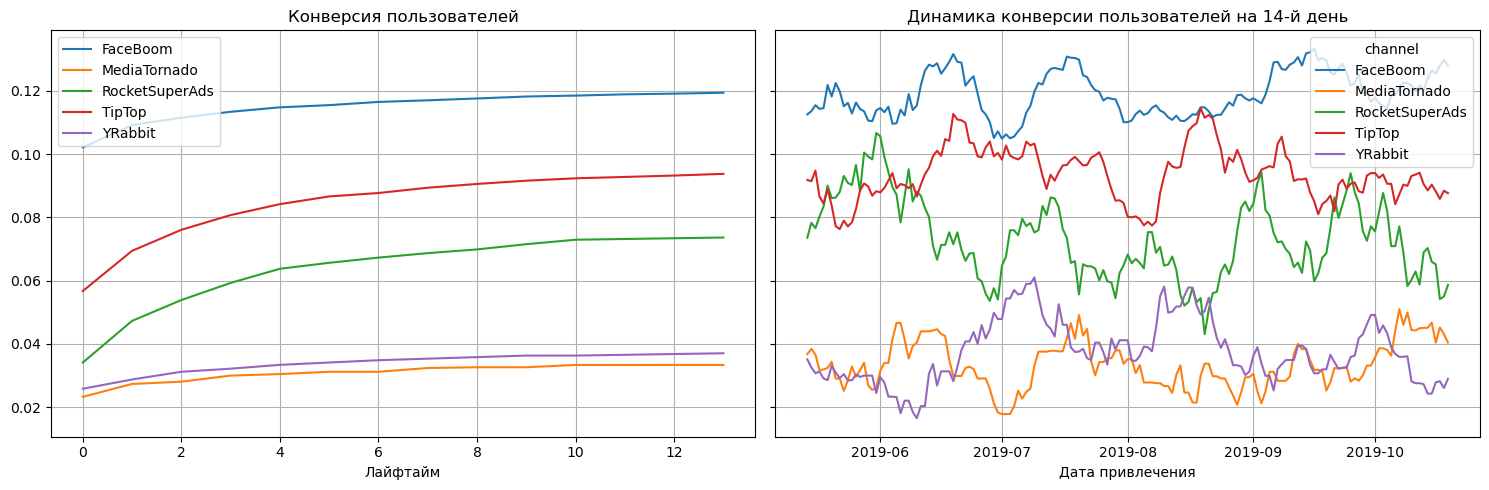

In [120]:
#конверсия
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    usa, orders, observation_date, horizon_days, dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

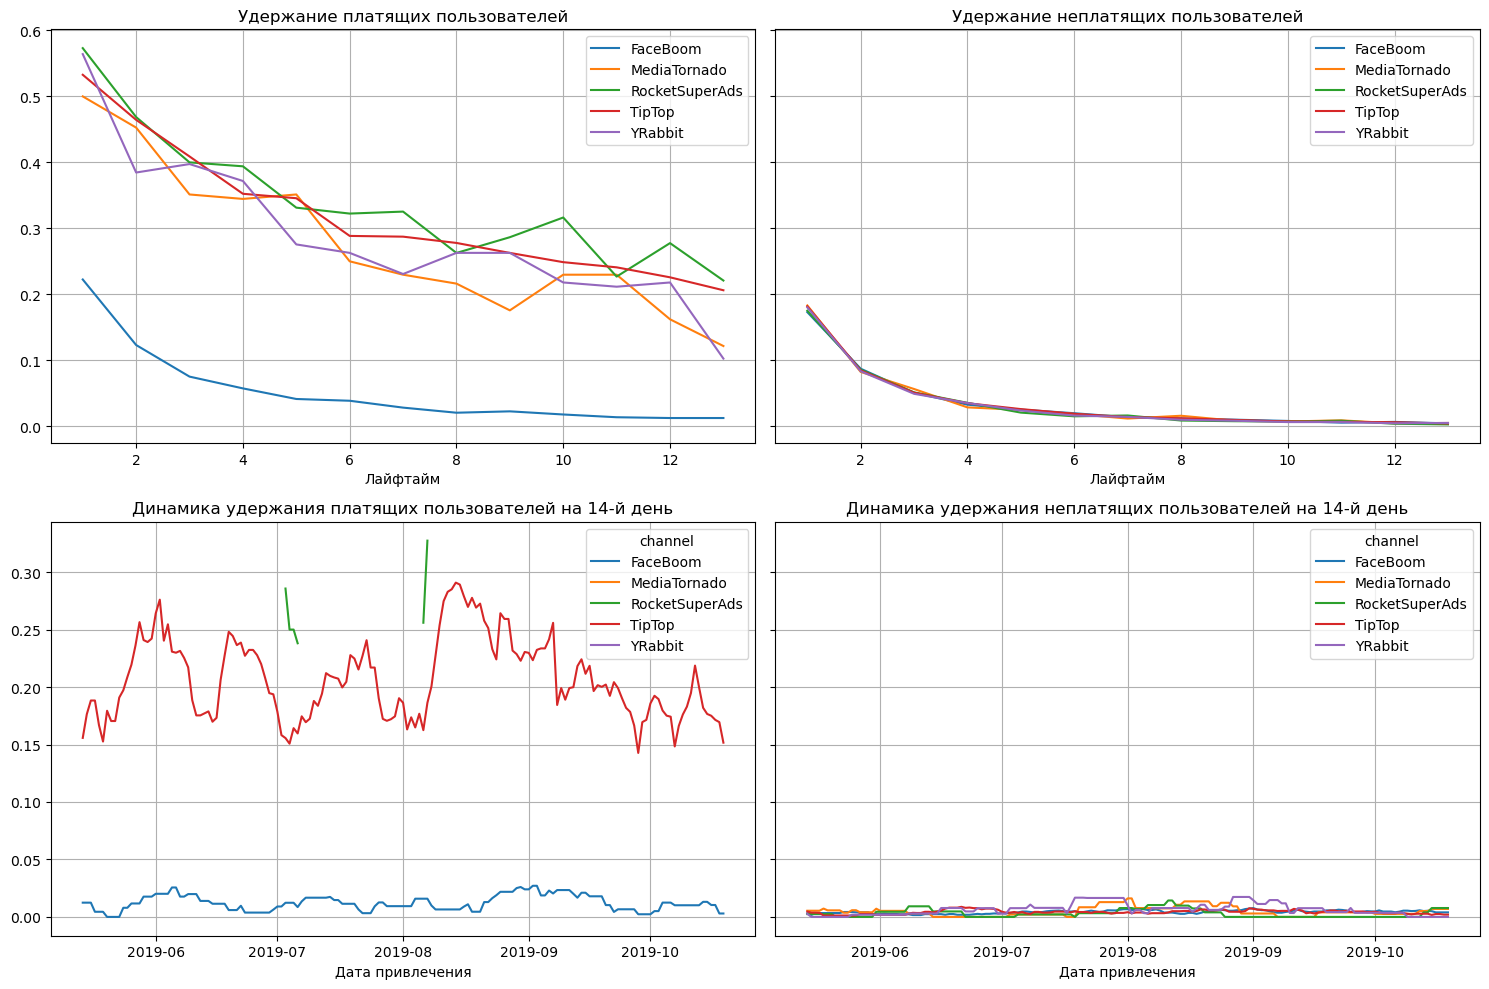

In [121]:
#удержание
retention_raw, retention, retention_history = get_retention(usa, visits, observation_date, horizon_days, dimensions=['channel'])
plot_retention(retention, retention_history, horizon_days)

Проверим конверсию и удержание в зависимости от устройств у пользователей США. 

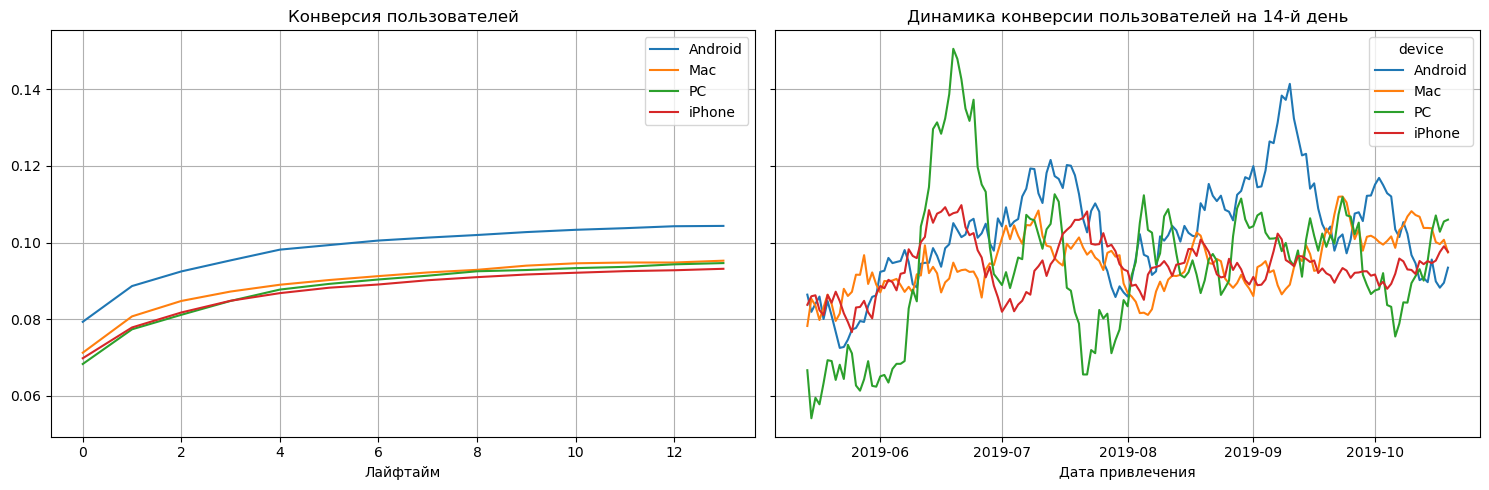

In [122]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    usa, orders, observation_date, horizon_days, dimensions=['device'])
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

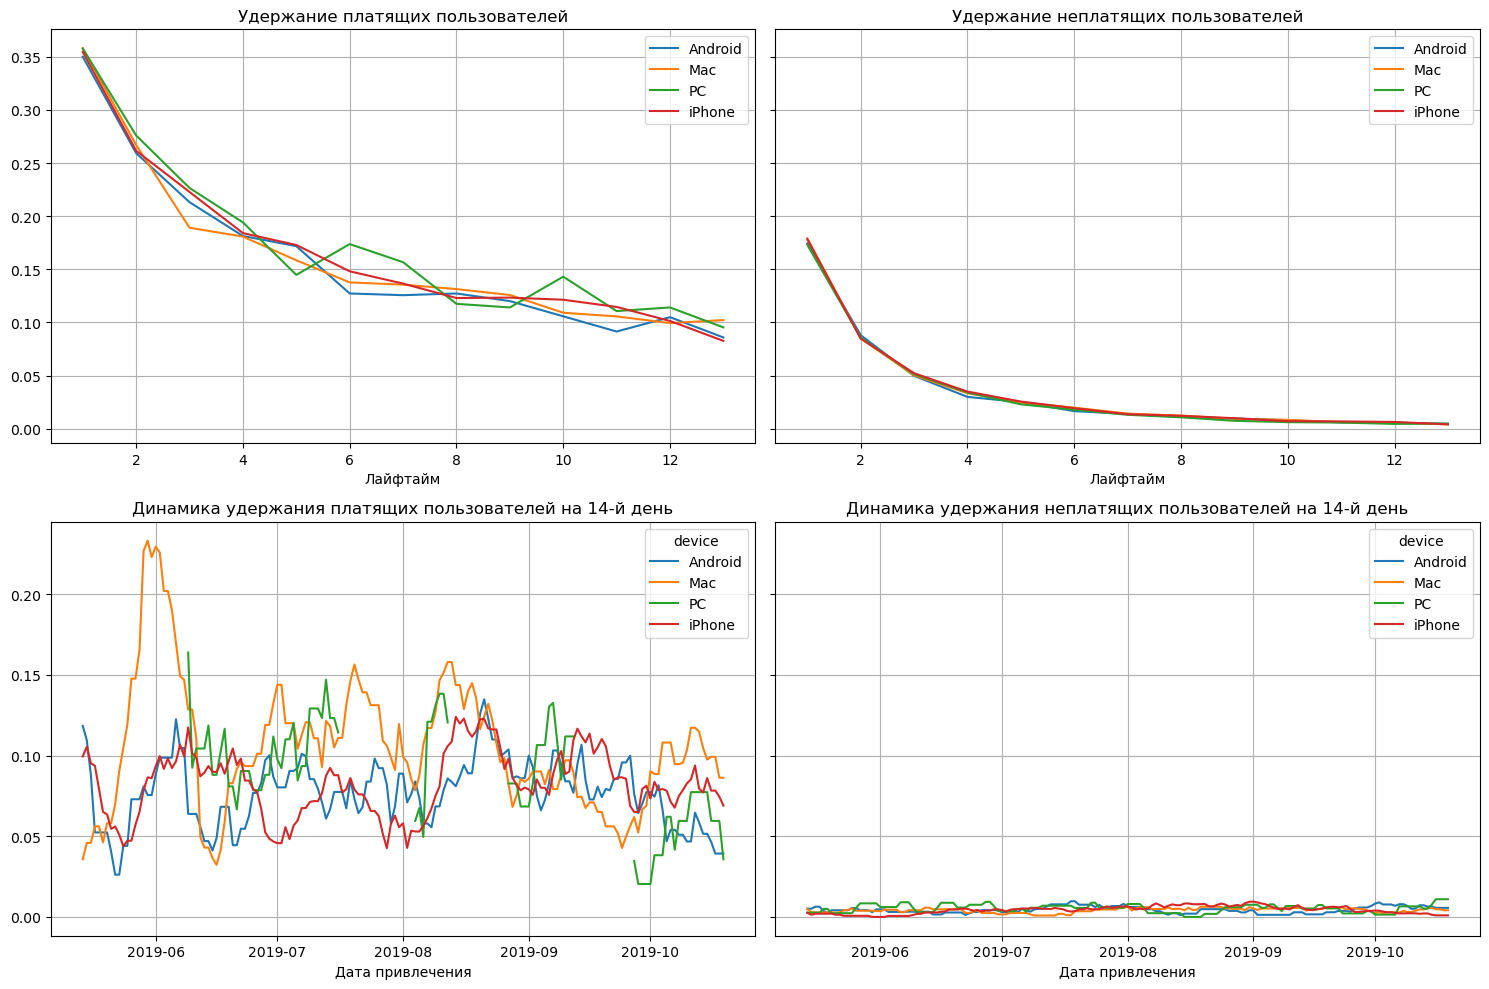

In [123]:
retention_raw, retention, retention_history = get_retention(usa, visits, observation_date, horizon_days, dimensions=['device'])
plot_retention(retention, retention_history, horizon_days)

В устройствах все в порядке. Выделяется только android  - у него конверсия выше, чем у остальных, а удержание такое же как у всех. 

Удивительно, но пользователи из FaceBoom конверируются гораздо лучше остальных, при этом у них самое низкое удержание и, как мы помним, уровень LTV с 3го дня лайфтайма не меняется. Также этот канал имеет один из двух наибольших бюджетов на рекламу и привлекает больше всего пользователей, и дает дорогих подписчиков, дороже только у TipTop. Конверсия у TipTop на втором месте после FaceBoom, а удержание выше и совпадает с другими каналами. Помним, что у TipTop самый высокий бюджет на рекламу. Значит, чтобы привлечение пользователя начало окупаться нужно снизить САС. 

**Вывод:**

**1) искать причину низкого удержания пользователей пришедших из FaceBoom.**


**2) снижать стоимость привлечения пользователей в канале TipTop** 

**ЕВРОПА, КАНАЛЫ ПРИВЛЕЧЕНИЯ**

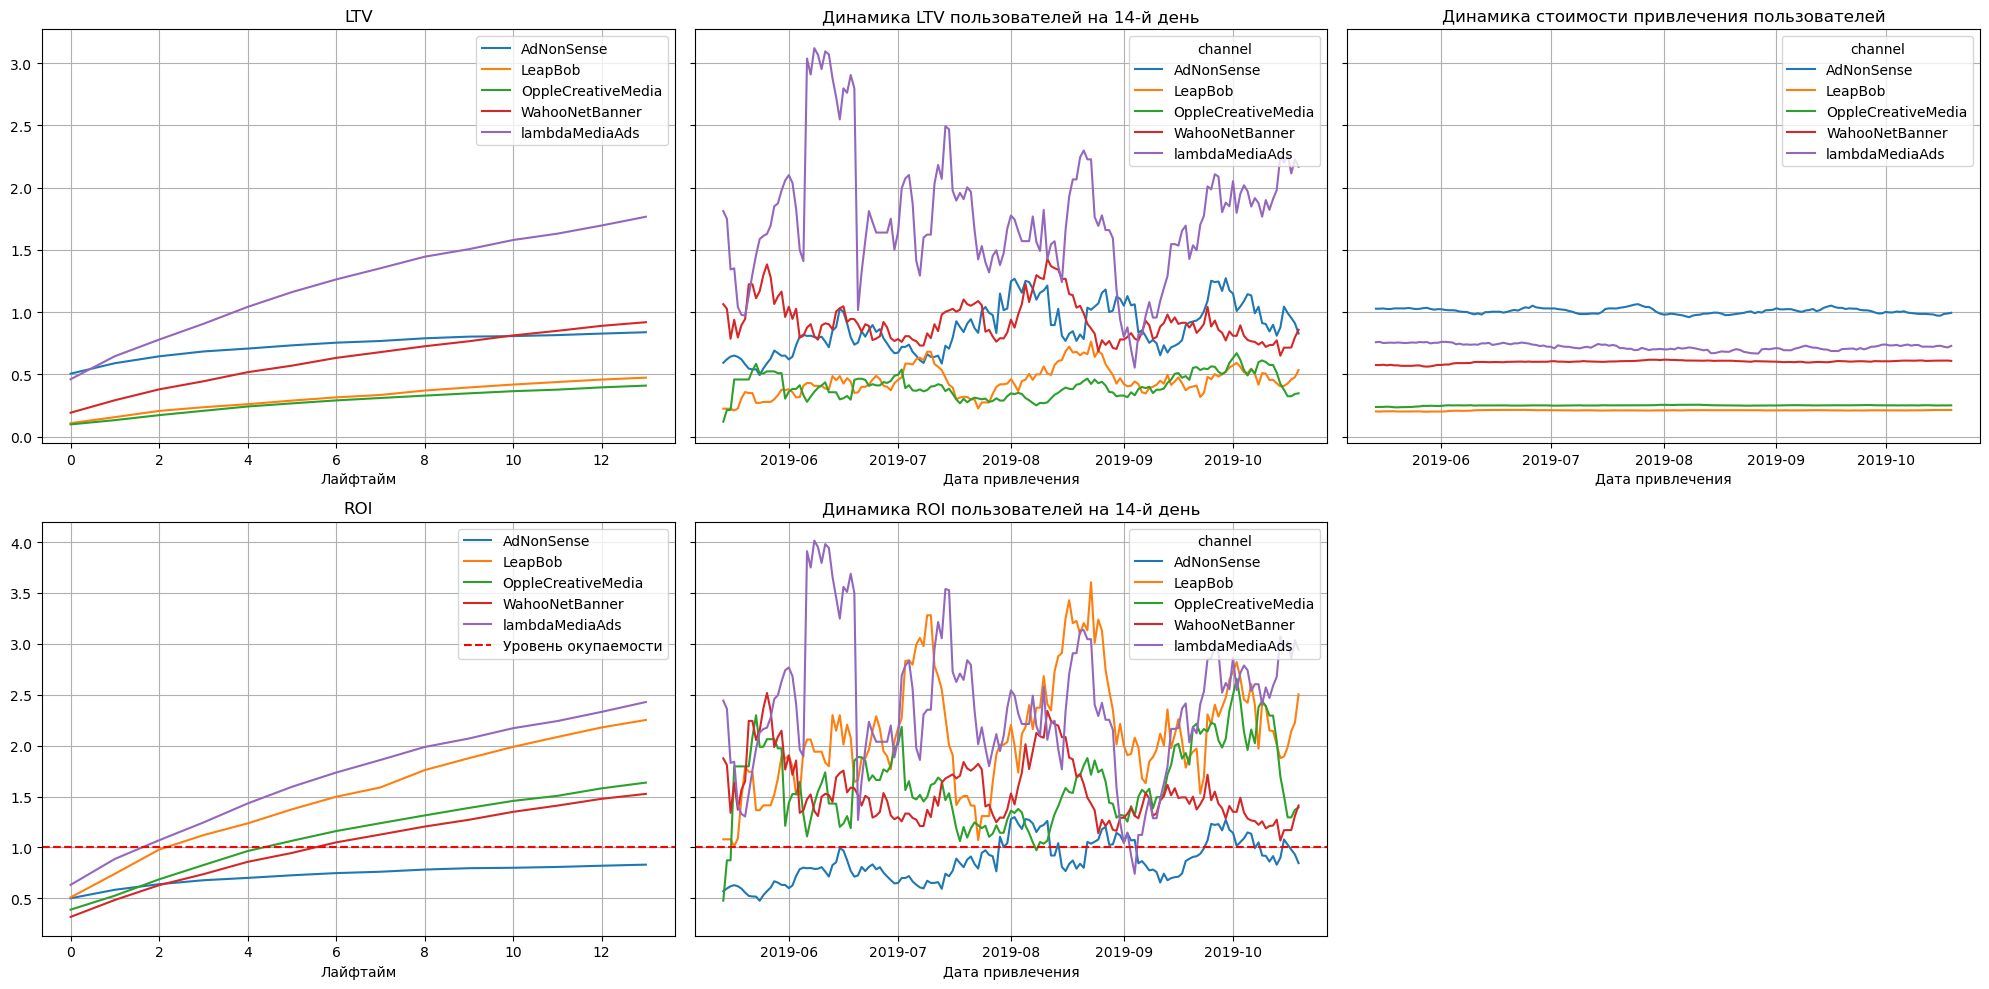

In [124]:
europe = profiles.query('region != "United States"')
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(europe, orders, observation_date, horizon_days, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Каналами привлечения европейских пользователей являются: AdNonSense, LeapBob, WahooNetBanner, OppleCreativeMedia, lambdaMediaAds. Из них только AdNonSense не окупается и дает меньше всего LTV, при этом в Европе это самый дорогой пользователь. И 4 место по расходованию бюджета на рекламу в общем. Лидер в показателях lambdaMediaAds - самый высокий  LTV и ROI. Окупается на 3 день и достигает от 200% до 250%. Проверим конверсию и удержание пользователей в каналах.  

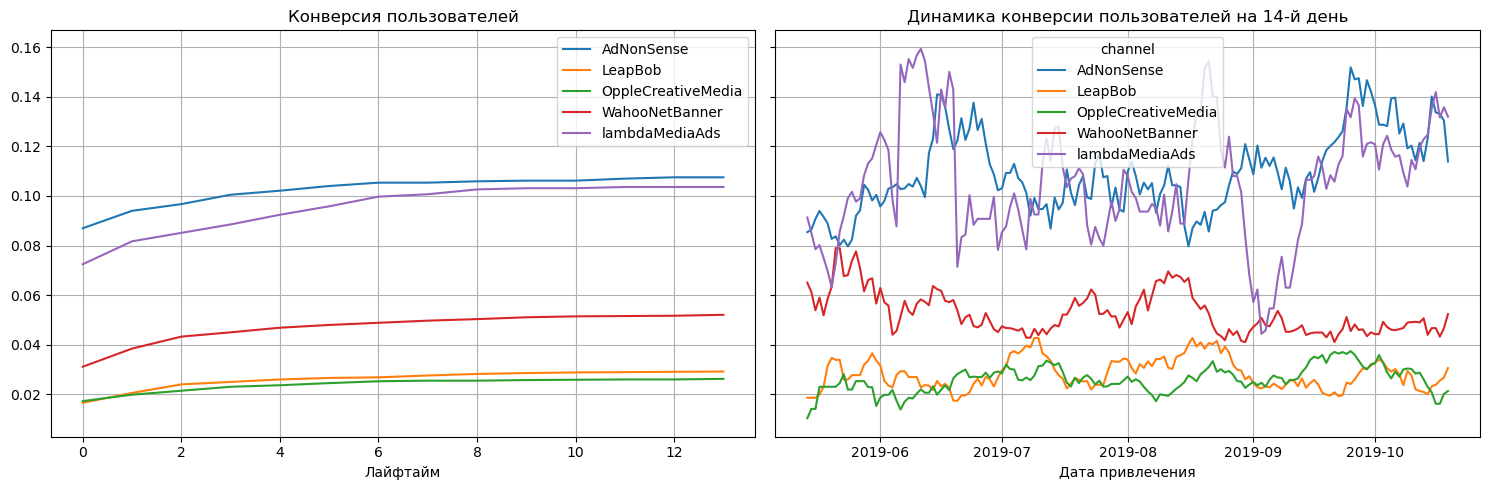

In [125]:
#конверсия
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    europe, orders, observation_date, horizon_days, dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

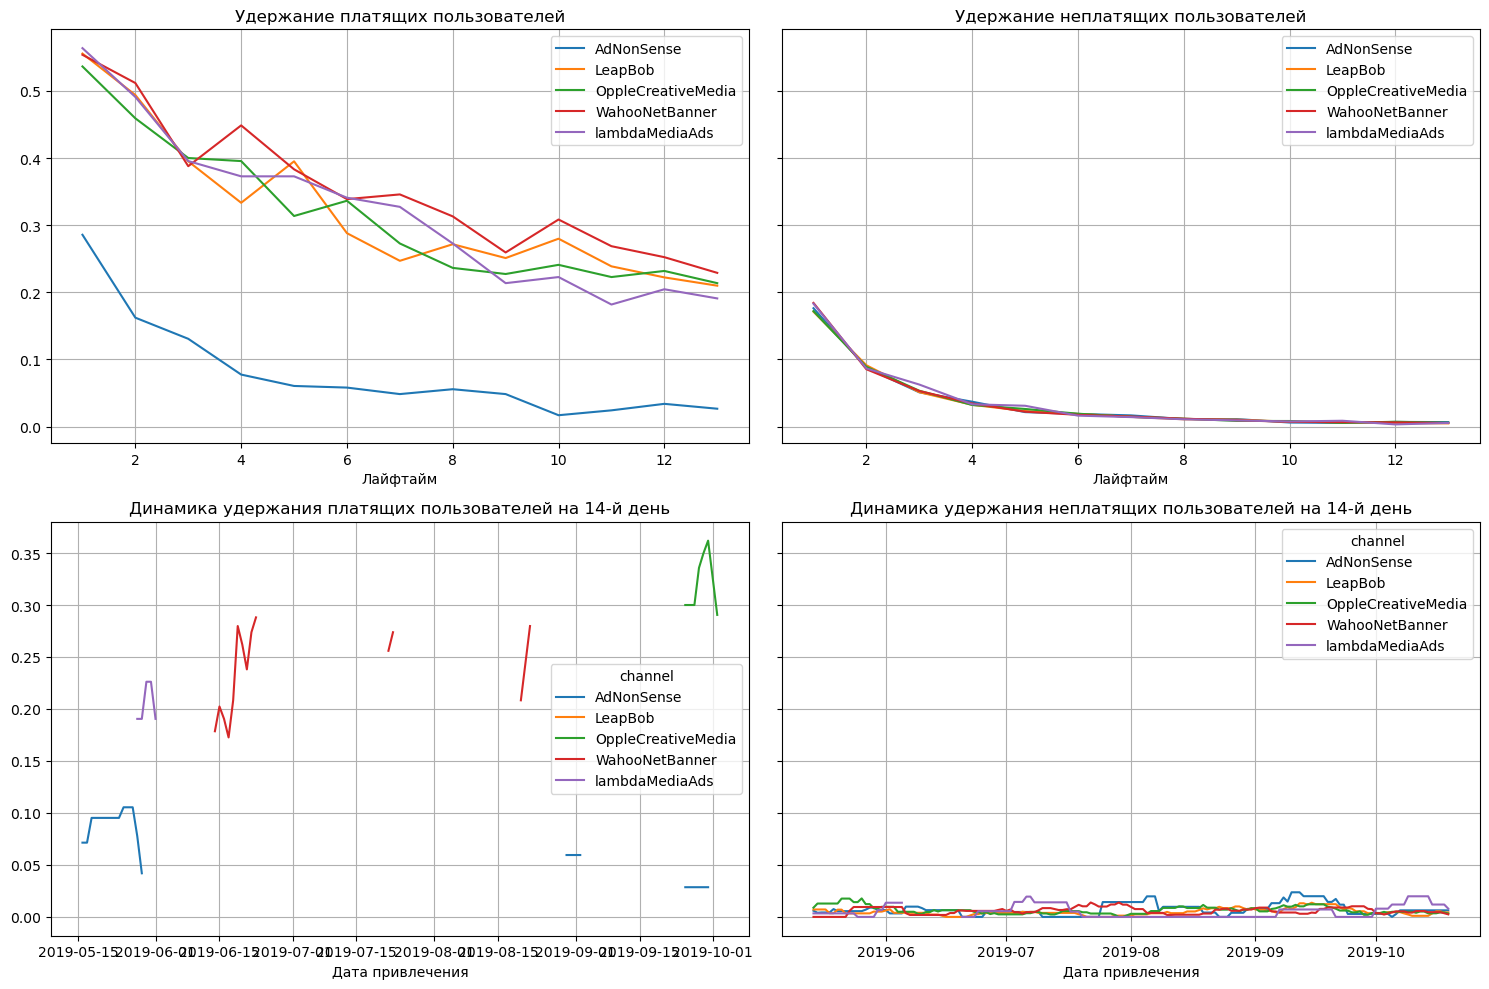

In [126]:
#удержание
retention_raw, retention, retention_history = get_retention(europe, visits, observation_date, horizon_days, dimensions=['channel'])
plot_retention(retention, retention_history, horizon_days)

Хорошая конверсия только у двух каналов: AdNonSense и lambdaMediaAds. И динамика конверсии у них довольно высокая. А вот удержание разное. У AdNonSense низкий % удержания, в то время как у других каналов он более-менее одинков. У WahooNetBanner удержание выше всех. 

Выше мы обратили внимание, что европейские пользователи предпочитают РС и android. Поэтому проверим конверсию и удержание и в этих метриках. 

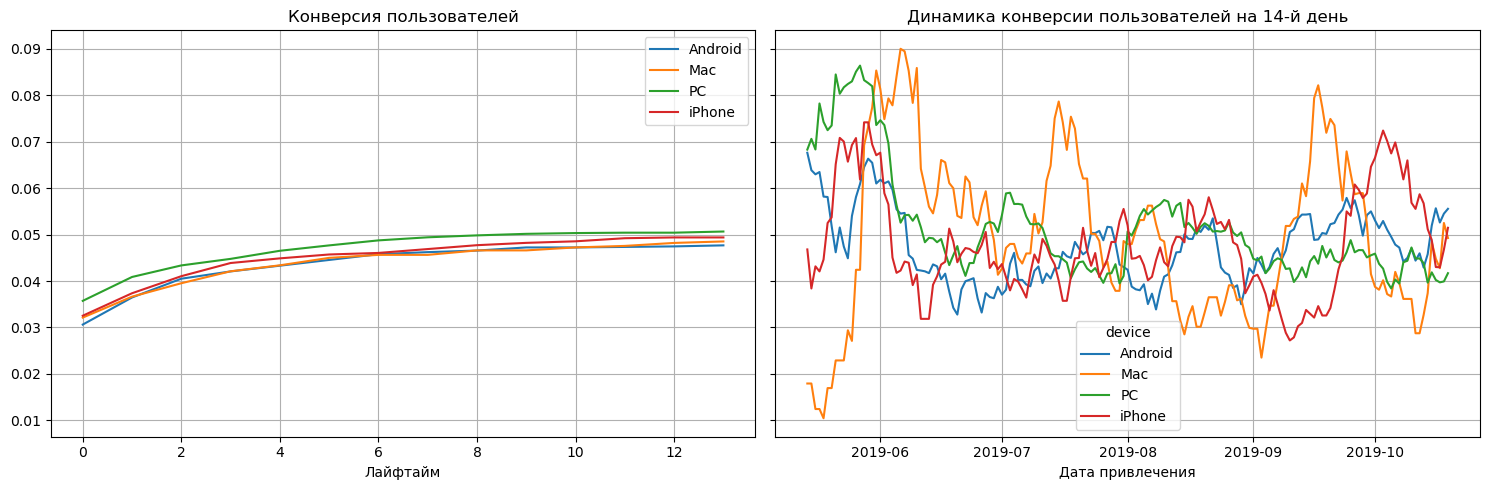

In [127]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    europe, orders, observation_date, horizon_days, dimensions=['device'])
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

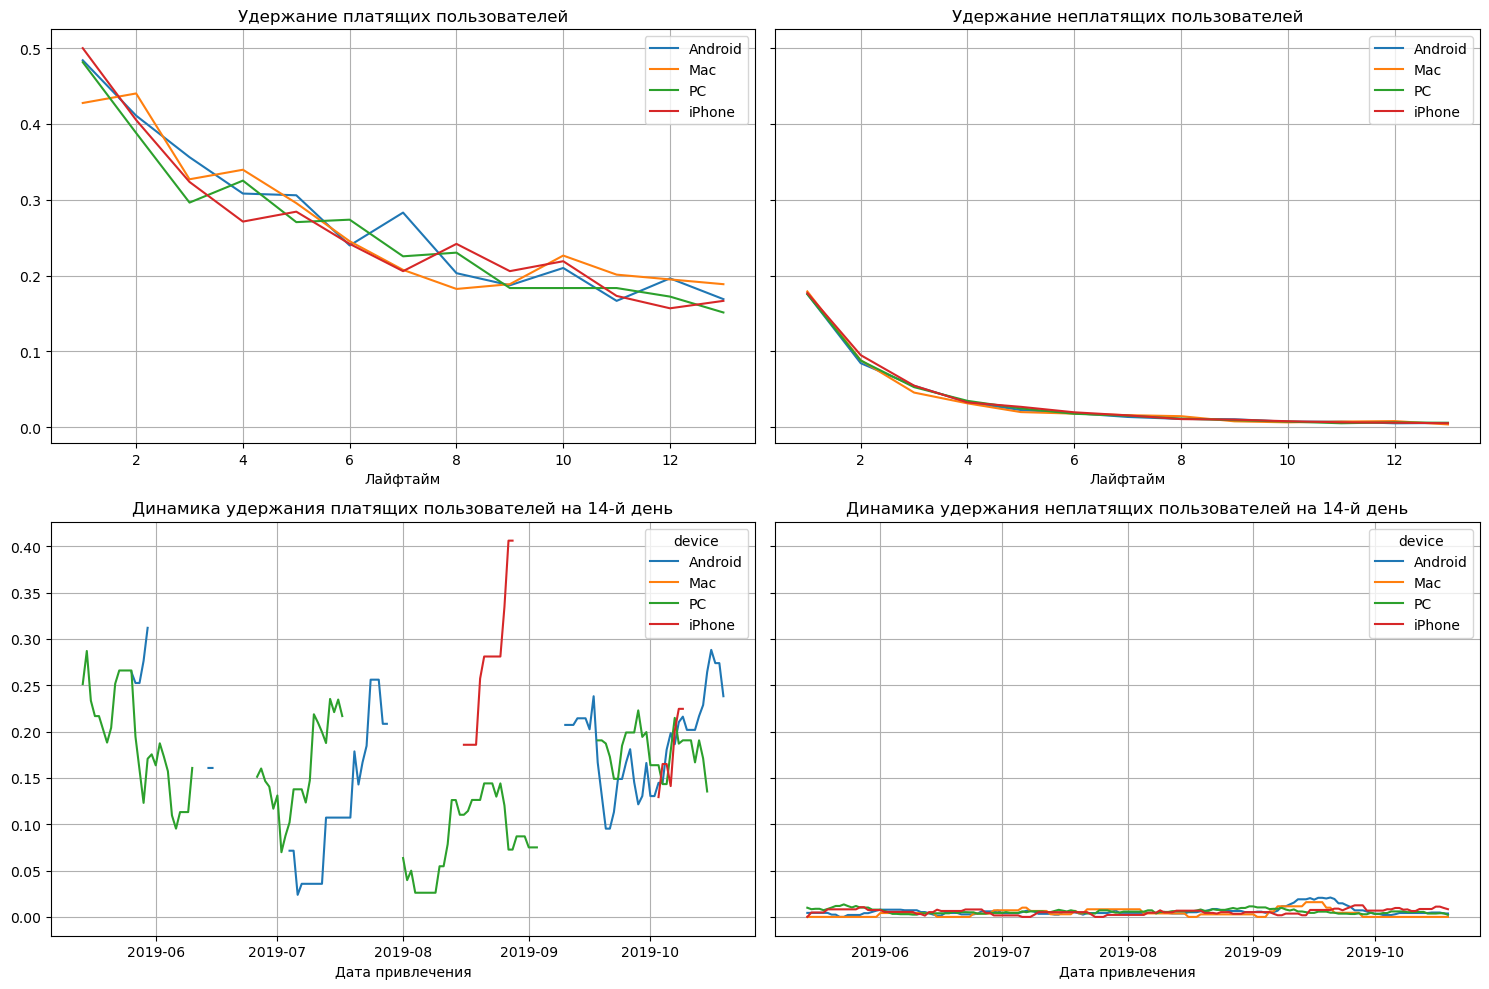

In [128]:
retention_raw, retention, retention_history = get_retention(europe, visits, observation_date, horizon_days, dimensions=['device'])
plot_retention(retention, retention_history, horizon_days)

С устройствами проблем не выявлено. Значит вывод такой же как и с FaceBoom - нужно выяснить причину плохого удержания пользователей из канала AdNonSense. Так как мы рассматриваем платящих пользователей, значит проблемы могут быть либо с повторной оплатой либо с авторизацией через этот канал.  

# ОБЩИЙ ВЫВОД:

В моем распоряжении было три датасета с данными: визиты, заказы и расходы на рекламу. В ходе предобработки данных были переименованы столбцы, названия столбцов приведены к нижнему регистру, изменены типы данных у столбцов с датами, проверены данные на дубликаты и пропуски. 

ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ:

Составили профили пользователей. Определили минимальную и максимальную дату привлечения пользователей. Минимальная дата привлечения:  2019-05-01, максимальная дата привлечения: 2019-10-27, разница 179 days. 

Выяснили, что пользователи приходят в приложение из США, Германии, Франции и Великобритании. Больше всего пользователей из США - 100 002, из них 6902 платящие или 4.6% от общего числа пользователей. На втором месте Великобритания - 17575 пользователей, из них 700 платящих (0,47% от общего числа), далее Франция - 17450 и 663 платящих (0,44%). На последнем месте пользователи из Германии 14981 и 616 платящих (0,41%). 

Всего 4 устройства с которых пользователи заходят в приложение: РС, Мас, Android и iPhone. Лидирующее место у пользователей iPhone(54479), на втором месте Android(35032), на третьем месте Мас(30042) и на четвертом РС(30455).  Также распределяются и платящие пользователи: iPhone - 3382(2,25% от общего числа), Android - 2050 (1,37%), Мас - 1912 (1,27%) и РС - 1537 (1,02%).  Получается, что 60% пользователей предпочитают смартфоны. 

Изучили каналы привлечения, всего их оказалось 11. Из них больше всего трафика дают: organic, FaceBoom, TipTop: 56439, 29144 и 19561 соответственно. Распределение платящей аудитории другое. Если брать соотношение платящей аудитории канала к неплатящей, то  получаем следующую тройку лидеров: FaceBoom(12,20%), AdNonSense(11,34%) и lambdaMediaAds(10,47) и меньше всего дает органический канал. А если смотреть на соотношение  платящих к общему числу пользователей, то это FaceBoom(2,37%), TipTop (1,25%) и organic(0,77%).

МАРКЕТИНГОВЫЙ АНАЛИЗ:

Общая сумма расходов на маркетинг составила 105 497. Распределение бюджета неравномерное. Больше всего затрат идет в TipTop - 54751,30. И FaceBoom - 32445,60. На третьем месте WahooNetBanner и 5151,00. Меньше всего расходов в YRabbit с 944,22. Мы построили графики динамики расходов по месяцам и по неделям. На их основании делаем вывод, что расходы на TipTop и FaceBoom начали расти практически с самого запуска приложения. И если FaceBoom вырос с 3000 до 6000, то TipTop с 3000 до 12000. 

Рассчитали САС - стоимость привлечения одного пользователя. Самый дорогой пользователь приходит из канала TipTop - 2,8, из FaceBoom - 1,11 и из AdNonSense - 1.00. Самые дешевые пользователи из каналов organic - 0,00, LeapBob - 0,21, MediaTornado - 0,22 и YRabbit - 0,22. 

ОЦЕНКА ОКУПАЕМОСТИ РЕКЛАМЫ. 

Реклама не окупается. К 14му дню лайфтайма ROI достигает только 80%. Динамика ROI на 14 день снизилась со 120% до 60%. При этом стоимость привлечения пользователей выросла почти в 2 раза с 0,8 до 1,4. 

Конверсия пользователей хорошая. Динамика на 14 день в диапазоне от 7,5% до 8,5%. Удержание платящих пользователей на низком уровне 3.5% на первый день и всего 1 % на 14 день. Неплатящие практически не удерживаются. График опускается с 2% до нуля. 

**Окупаемость с разбивкой по устройствам.**

Только у пользователей РС показатель ROI выходит на окупаемость. Также замечу, что ROI у пользователей РС окупается на 12 день только. К тому же уровень LTV у РС ниже, чем у остальных. Значит они приносят компании меньше денег и при этом окупаются. Судя по динамике ROI до сентября 2019 года такие пользователи окупались очень хорошо. В то же время, затраты на привлечение начали расти тоже в сентябре. Значит тут есть корреляция - затраты выросли - ROI упал.

Выяснили какие устройства предпочитают пользователи из разных стран. в США предпочитают пользоваться iPhone, Mac и Android и гораздо реже PC. В Европе наоборот пользователи предпочитают РС и Android и меньше Мас и iPhone.

**Окупаемость с разбивкой по странам.**

LTV у США выше, чем у Европы. Значит американец покупает больше европейца. Об этом же нам говорит график динамики LTV: пользователи США стабильно выше пользователей из европейских стран. Уровень САС у США начал расти практически сразу и увеличился в 2 раза. В это же время стоимость привлечения европейского пользователя снизилась и стабилизировалась на уровне 0,4. ROI пользователя из США низкий, затраты на рекламу не окупаются ни в один из дней лайфтайма и не поднимаются выше 60%. В динамике мы видим снижение ROI буквально через месяц после старта приложения. Прослеживается корреляция между повышением САС и снижением ROI. У европейских пользователей все хорошо, даже не смотря на то, что LTV у них ниже. ROI на 5-7 день лайфтайма выходит на окупаемость и достигает 150%. В динамике все также хорошо, все три европейские страны находятся в зоне окупаемости. 

**Окупаемость рекламы с разбивкой по каналам привлечения**

Пользователи с самым высоким LTV приходят из lambdaMediaAds и TipTop, меньше всего платящих пользователей дают OppleCreativeMedia и LeapBob. Динамика САС у всех каналов стабильна, кроме TipTop и RocketSuperAds. Стоимость пользователя из TipTop выросла в 3,5 раза, стоимость пользователя из RocketSuperAds снизилась в 2 раза. Не все каналы привлечения окупаются: FaceBoom,AdNonSense и TipTop не выходят на уровень окупаемости. Остальные каналы со 2 по 7 день лайфтайма выходят за отметку 100%. Причем те, кто выходят раньше - дают и ROI выше YRabbit, MediaTornado и lambdaMediaAds.

Далее мы разделили пользователей  на два региона: США и Европу и посмотрели показатели конверсии и удержания отдельно. 
США. 
Пользователи из FaceBoom конверируются гораздо лучше остальных, при этом у них самое низкое удержание и, как мы помним, уровень LTV с 3го дня лайфтайма не меняется. Также этот канал имеет один из двух наибольших бюджетов на рекламу и привлекает больше всего пользователей, и дает дорогих подписчиков, дороже только у TipTop. Конверсия у TipTop на втором месте после FaceBoom, а удержание выше и совпадает с другими каналами. Помним, что у TipTop самый высокий бюджет на рекламу. Значит, чтобы привлечение пользователя начало окупаться нужно снизить САС. 
ЕВРОПА. 
Каналами привлечения европейских пользователей являются: AdNonSense, LeapBob, WahooNetBanner, OppleCreativeMedia, lambdaMediaAds. Из них только AdNonSense не окупается и дает меньше всего LTV, при этом в Европе это самый дорогой пользователь. И 4 место по расходованию бюджета на рекламу в общем. Лидер в показателях lambdaMediaAds - самый высокий LTV и ROI. Окупается на 3 день и достигает от 200% до 250%.  Хорошая конверсия только у двух каналов: AdNonSense и lambdaMediaAds. И динамика конверсии у них довольно высокая. А вот удержание разное. У AdNonSense низкий % удержания, в то время как у других каналов он более-менее одинков. У WahooNetBanner удержание выше всех.

## РЕКОМЕНДАЦИИ: 

1) искать причину плохого удержания пользователей из FaceBoom

2) снижать стоимость привлечения пользователей в канале TipTop

3) выяснить причину плохого удержания пользователей из канала AdNonSense

Возможно проблемы либо с повторной оплатой, либо с авторизацией через проблемный канал.
